# Project: Modelling the Spread of Covid-19

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import cm
import math
import pandas as pd
from scipy.fftpack import fft,fftfreq
import scipy.stats as stats
import json
import random
import warnings
import dynetx as dn
import networkx as nx
from bokeh.io import show
import ndlib.models.dynamic as dm
from ndlib.utils import multi_runs
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments.NodeStochastic as ns
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

no display found. Using non-interactive Agg backend


In [2]:
%matplotlib inline

# Problem 1: Gillespie’s Direct Algorithm
Begin with SIR without demography, then add demography, and finally add imports to the model.
## 1.1 SIR without demograpy
# Build a basic SIR model as class

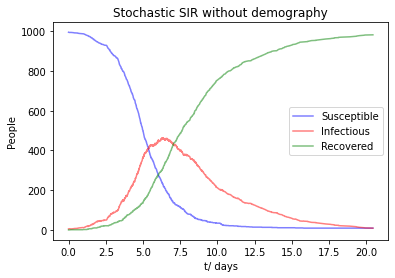

In [3]:
class SIR_basic(object):

    # Set the initial parameters
    def __init__(self, S0, I0, R0, beta, gamma, t_stop):
        self.S, self.I, self.R, self.t = [], [], [], []
        self.S.append(S0), self.I.append(I0), self.R.append(R0)
        self.t.append(0)

    
    # Simulate random events happening
    def events(self):
        while self.t[-1] < t_stop:
            N = self.S[-1]+self.I[-1] + self.R[-1]
            Rate1 = beta * self.S[-1] * self.I[-1]/N
            Rate2 = gamma * self.I[-1]
           
            Rate_total = Rate1 + Rate2 
            
            if Rate_total == 0:
                break
            ran1,ran2 = np.random.uniform(0,1), np.random.uniform(0,1) * Rate_total
            t_step = -math.log(ran1) / Rate_total
            self.t.append(self.t[-1]+t_step)

            if ran2 < Rate1:          # Event 1: infection, 0.01??
                self.S.append(self.S[-1]-1)
                self.I.append(self.I[-1]+1)
                self.R.append(self.R[-1])
            else:                     # Event 2: recovery
                self.S.append(self.S[-1])
                self.I.append(self.I[-1]-1)
                self.R.append(self.R[-1]+1)
            
        return [self.t, self.S, self.I, self.R]

# Set the initial values
S0 = 995
I0 = 5
R0 = 0
beta = 1.4
gamma = 0.3
t_stop = 20

# Operate class function

results = SIR_basic(S0, I0, R0, beta, gamma, t_stop).events()


# Plot basic SIR model
plt.plot(results[0], results[1], c="b", alpha=0.5, label="Susceptible")
plt.plot(results[0], results[2], c="r", alpha=0.5, label="Infectious")
plt.plot(results[0], results[3], c="g", alpha=0.5, label="Recovered")
plt.legend()
plt.xlabel("t/ days")
plt.ylabel("People")
plt.title("Stochastic SIR without demography")
plt.show()

## 1.2 SIR model with demography and imports

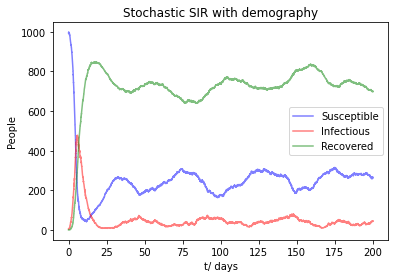

In [4]:
# Build a SIR model with demography and imports as class

class SIR_demography(object):

    # Set the initial parameters
    def __init__(self, S0, I0, R0, beta, gamma, mu, epsilon, t_stop):
        self.S,self.I,self.R,self.t = [],[],[],[]
        self.S.append(S0), self.I.append(I0), self.R.append(R0)
        self.t.append(0)
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.epsilon = epsilon
    
    # Simulate random events happening
    def events(self):
        while self.t[-1] < t_stop:
            N = self.S[-1] + self.I[-1] + self.R[-1]
            
            Rate1 = self.beta * self.S[-1] * self.I[-1] / N
            Rate2 = self.gamma * self.I[-1]
            Rate3 = self.mu * N
            Rate4 = self.mu * self.S[-1]
            Rate5 = self.mu * self.I[-1]
            Rate6 = self.mu * self.R[-1]
            Rate7 = self.epsilon 
            Rate_total = Rate1 + Rate2 + Rate3 + Rate4 + Rate5 + Rate6 + Rate7
            if Rate_total == 0:
                break
            ran1,ran2 = np.random.uniform(0,1), np.random.uniform(0,1) * Rate_total
            t_step = -math.log(ran1) / Rate_total
            self.t.append(self.t[-1] + t_step)

            if ran2 < Rate1:                     
                # Event 1: Infection
                SIR_demography.events_stay(self)
                self.S[-1] -= 1
                self.I[-1] += 1
            elif ran2 < (Rate1 + Rate2):   
                # Event 2: Recovery
                SIR_demography.events_stay(self)
                self.I[-1] -= 1
                self.R[-1] += 1
            elif ran2 < (Rate1 + Rate2 + Rate3):
                # Event 3: Birth   
                SIR_demography.events_stay(self)
                self.S[-1] += 1
            elif ran2 < (Rate1 + Rate2 + Rate3 + Rate4):  
                # Event 4: Death in S   
                SIR_demography.events_stay(self)
                self.S[-1] -= 1
            elif ran2 < (Rate1 +Rate2 + Rate3 + Rate4 + Rate5):  
                # Event 5: Death in I 
                SIR_demography.events_stay(self)
                self.I[-1] -= 1
            elif ran2 < (Rate1 + Rate2 + Rate3 + Rate4 + Rate5 + Rate6): 
                # Event 6: Death in R  
                SIR_demography.events_stay(self)
                self.R[-1] -= 1
            else:
                # Event 7: Imports
                SIR_demography.events_stay(self)
                self.I[-1] += 1
            
        return [self.t, self.S, self.I, self.R]

    def events_stay(self):    
        self.S.append(self.S[-1])
        self.I.append(self.I[-1])
        self.R.append(self.R[-1])

# Set the initial values
S0 = 995
I0 = 5
R0 = 0
beta = 1.4
gamma = 0.3
mu=1/60
epsilon = 0.001
t_stop = 200

# Operate class function

results = SIR_demography(S0, I0, R0, beta, gamma, mu, epsilon, t_stop).events()

# Plot SIR model
plt.plot(results[0], results[1], c="b", alpha=0.5, label="Susceptible")
plt.plot(results[0], results[2], c="r", alpha=0.5, label="Infectious")
plt.plot(results[0], results[3], c="g", alpha=0.5, label="Recovered")
plt.legend()
plt.xlabel("t/ days")
plt.ylabel("People")
plt.title("Stochastic SIR with demography")
plt.show()

## 1.3 Five hallmarks
### 1.3.1 Variability

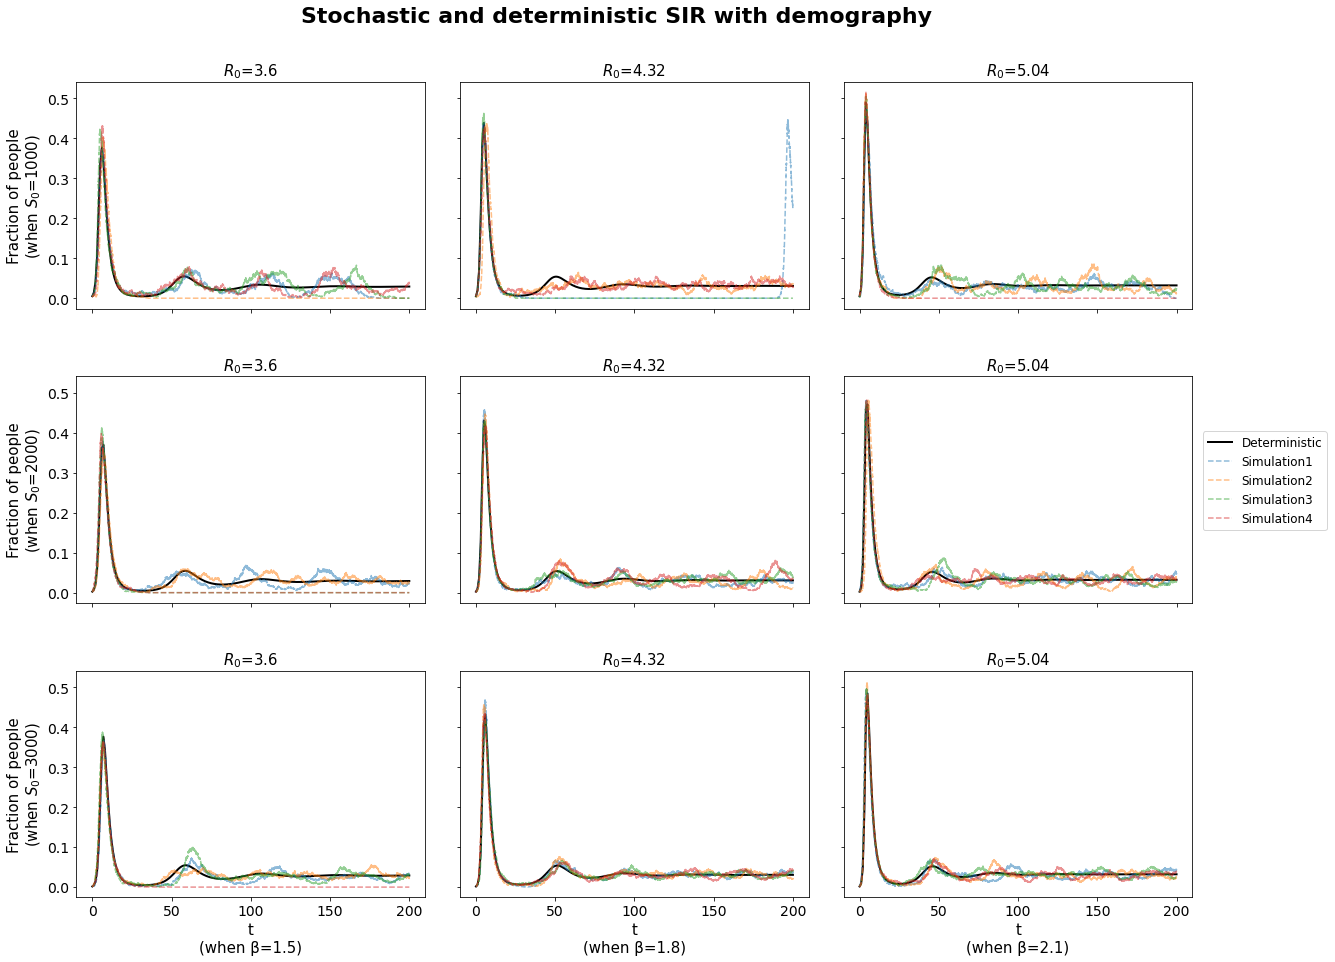

In [5]:
# Build the SIR model with demograhy
def SIR_demography_deterministic(y,t,beta,gamma,mu,N):
    S, I, R = y
    dSdt = mu*N - beta*S*I/N - mu*S
    dIdt = beta*S*I/N-mu*I-gamma*I
    dRdt = gamma*I-mu*R
    return [dSdt,dIdt,dRdt]

# Set the initial values
S0_list = [1000, 2000, 3000] 
I0 =  5
R0_r = 0
beta = [1.5, 1.8, 2.1]
gamma = 0.4
mu = 1/60
epsilon = 0.001
t = np.linspace(0,200,201)
t_stop = 200

# Plot all combinations of beta and mu into the model
fig,ax=plt.subplots(nrows=len(S0_list),ncols=len(beta),sharex=True,sharey=True,figsize=(20,15))
for i in range(len(S0_list)):
    for j in range(len(beta)):
        N = S0_list[i] + I0 + R0_r
        result1=odeint(SIR_demography_deterministic,[S0_list[i],I0,R0],t,args=(beta[j],gamma,mu,N))
        R0 = beta[j]/(gamma+mu)
        ax[i,j].figsize=(3,3)
        ax[i,j].plot(t, [m/N for m in result1[:,1]], alpha=1, color='black', lw = 2) 

        # Plot stochastic model
        for k in range(4):
            results2 = SIR_demography(S0_list[i], I0, R0_r, beta[j], gamma, mu, epsilon, t_stop).events()
            ax[i,j].plot(results2[0],[n/N for n in results2[2]] , linestyle='--', alpha=0.5, label="Infectious")

        ax[i,j].set_title('$R_0$='+str(round(R0,2)),fontsize=15)
        ax[2,j].set_xlabel('t'+'\n(when '+ chr(946)+'='+str(beta[j])+')',fontsize=15)
        ax[i,0].set_ylabel('Fraction of people'+'\n(when '+ '$S_0$'+'='+str(round(S0_list[i],4))+')',fontsize=15)
        ax[i,j].tick_params(labelsize=14)

plt.subplots_adjust(hspace=0.3,wspace=0.1)
fig.legend(labels=['Deterministic','Simulation1','Simulation2','Simulation3','Simulation4'],loc="right",borderaxespad=0.7,fontsize=12)
fig.suptitle('Stochastic and deterministic SIR with demography',y=0.95,weight='bold',fontsize=22)
plt.show()

### 1.3.2 Negative co-variances

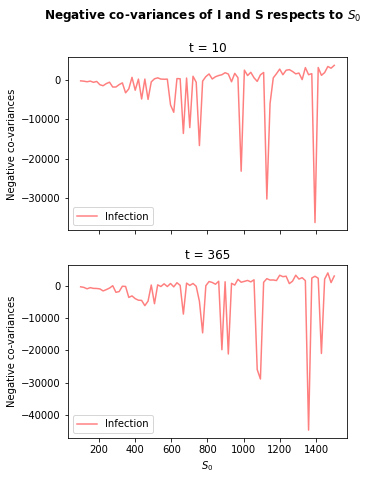

In [6]:
# Set the initial values
S0_list = np.linspace(100,1500,80)
I0 = 5
R0 = 0
beta = 1.4
gamma = 0.3
mu=1/60
epsilon = 0.001
t_stop1 = 10
t_stop2 = 365
results1=[]
results2=[]

# Operate class function
for i in S0_list:
    results = SIR_demography(i,I0,R0,beta,gamma, mu, epsilon, t_stop1).events()
    results1.append(np.cov(results[1],results[2])[0][1])
results = 0
for i in S0_list:
    results = SIR_demography(i,I0,R0,beta,gamma, mu, epsilon, t_stop2).events()
    results2.append(np.cov(results[1],results[2])[0][1])

# Plot SIR model
fig, ax = plt.subplots(2, 1, figsize = [5, 7],sharex=True)
ax[0].plot(S0_list,results1,'-', c="r", alpha=0.5, label="Infection")
ax[0].set_title("t = " +str(t_stop1))
ax[1].plot(S0_list,results2,'-', c="r", alpha=0.5, label="Infection")
ax[0].set_title("t = " +str(t_stop1))
ax[1].set_title("t = " +str(t_stop2))
plt.xlabel("$S_0$")
ax[0].set_ylabel("Negative co-variances")
ax[1].set_ylabel("Negative co-variances")
ax[0].legend()
ax[1].legend()
fig.suptitle("Negative co-variances of I and S respects to $S_0$", weight = 'bold')
plt.show()

### 1.3.2 Increased transients

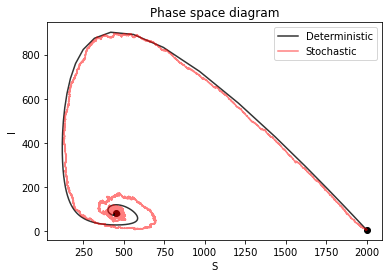

In [7]:
# Build the SIR model with demograhy
def SIR_demography_deterministic(y,t,beta,gamma,mu,N):
    S, I, R = y
    dSdt = mu*N - beta*S*I/N - mu*S
    dIdt = beta*S*I/N-mu*I-gamma*I
    dRdt = gamma*I-mu*R
    return [dSdt,dIdt,dRdt]

# Set the initial values
S0 = 2000
I0 = 5
R0_r = 0
beta = 1.4
gamma = 0.3
mu=1/60
epsilon = 0.001
t=np.linspace(0,200,400)
t_stop = 200

# Deterministic model
N = S0 + I0 + R0_r
R0 = beta/(gamma+mu)
S_fix = 1/R0                 # Get the fixed point
I_fix = mu*(R0-1)/beta
R_fix = 1-1/R0-mu*(R0-1)/beta              
results1 = odeint(SIR_demography_deterministic,[S0,I0,R0_r],t,args=(beta,gamma,mu,N)).T    
plt.plot(results1[0], results1[1],'black',alpha=0.8,label = 'Deterministic') 
plt.scatter(S0,N-S0,c='black')

# Stochasitc model
results2=SIR_demography(S0,I0,R0,beta,gamma, mu, epsilon, t_stop).events()
plt.plot(results2[1], results2[2],'red',alpha=0.5,label = 'Stochastic')

           
plt.scatter(S_fix*N,I_fix*N,c='black', marker='o')
plt.xlabel("S")
plt.ylabel("I")
plt.title("Phase space diagram")
plt.legend()
plt.show()

### 1.3.2 Stochastic resonance

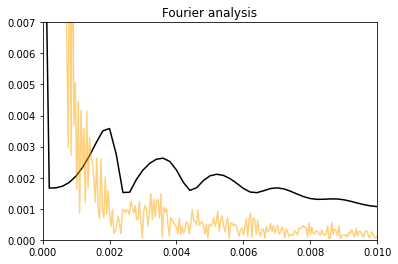

In [8]:
# Build the SIR model with demograhy
def SIR_demography_deterministic(y,t,beta,gamma,mu,N):
    S, I, R = y
    dSdt = mu*N - beta*S*I/N - mu*S
    dIdt = beta*S*I/N-mu*I-gamma*I
    dRdt = gamma*I-mu*R
    return [dSdt,dIdt,dRdt]

def Fourier(t, y):
    N1=len(t)                        
    x_fre= fftfreq(len(y))  # Get the frequency
    x_half=x_fre[range(int(N1/2))]      # Because of symmetry, half the interval
    y_f=fft(y)              # Fast Fourier transform
    y_abs=np.abs(y_f)                   # Get the absolute value
    y_normalization=y_abs/N1            # Normalization processing
    y_normalization_half=y_normalization[range(int(N1/2))]   # Half the interval  
    return [x_half,y_normalization_half]

# Set the initial values
S0 = 1000
I0 = 5
R0_r = 0
N = S0 + I0 + R0_r
beta = 1.9
gamma = 0.7
mu=1/60
epsilon = 0.01
t=np.linspace(0,500,5000)
t_stop = 500

# Deterministic
results1 = odeint(SIR_demography_deterministic,[S0,I0,R0_r],t,args=(beta,gamma,mu,N)).T
results2 = Fourier(t,[m/N for m in results1[1]]) 

# Stochastic
results3 = SIR_demography(S0,I0, R0_r, beta, gamma, mu, epsilon, t_stop).events()
results4 = Fourier(t,[n/N for n in results3[2]])

plt.plot(results2[0], results2[1],'black')
plt.plot(results4[0],results4[1],'orange',alpha=0.5)
plt.xlim(0,0.01)
plt.ylim(0,0.007)
plt.title("Fourier analysis")
plt.show()

### 1.3.2 Extinctions

No handles with labels found to put in legend.


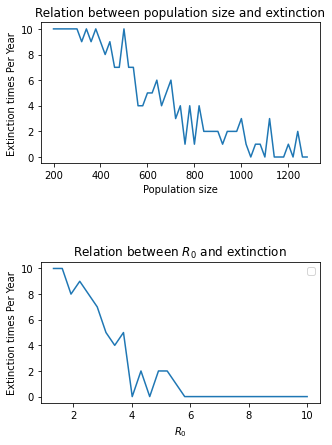

In [9]:
# Set the initial values
S0_list = np.arange(200,1300,20)
I0 = 5
R0_r = 0
beta = 1.4
gamma = 0.3
mu=1/60
epsilon = 0
t_stop = 365
times_total1 = []
times_total2 = []

# Explore the population size
for i in S0_list:
    times = 0
    for j in range(10):

        # Stochasitc model
        results = SIR_demography(i,I0, R0_r, beta, gamma, mu, epsilon, t_stop).events()
        for k in results[2]:
            if k == 0:
                times = times + 1
                break
    times_total1.append(times)

# Explore the R0
beta_list = np.linspace(0.4, 3, 30)
for i in beta_list:
    times = 0
    for j in range(10):

        # Stochasitc model
        results = SIR_demography(1000, I0, R0_r, i, gamma, mu, epsilon, t_stop).events()
        for k in results[2]:
            if k == 0:
                times = times + 1
                break
    times_total2.append(times)


fig, ax = plt.subplots(2, 1, figsize = [5, 7])
ax[0].plot(S0_list, times_total1,'-')
ax[1].plot([i/gamma for i in beta_list], times_total2,'-')
fig.subplots_adjust(hspace = 0.7, wspace = 0.2)
ax[0].set_xlabel("Population size")
ax[0].set_ylabel("Extinction times Per Year")
ax[0].set_title("Relation between population size and extinction")
ax[1].set_xlabel("$R_0$")
ax[1].set_ylabel("Extinction times Per Year")
ax[1].set_title("Relation between $R_0$ and extinction")
plt.legend()
plt.show()

### 1.3.2 Advanced topic: The first passage time

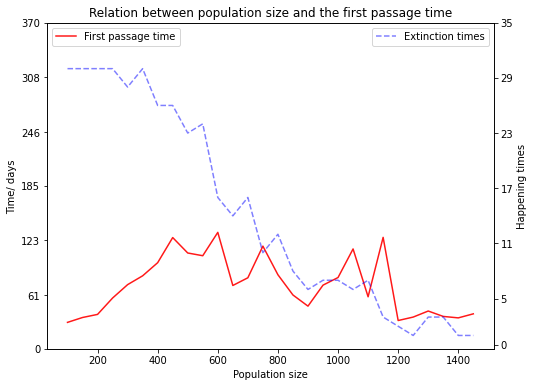

In [10]:
# Set the initial values
S0_list = np.arange(100,1500, 50)
I0 = 5
R0_r = 0
beta = 1.4
gamma = 0.3
mu=1/60  
epsilon = 0
t_stop = 365
times_total = []
n_total = []

for i in S0_list:
    n = 0
    times = 0
    
    for j in range(30):
        
        # Stochasitc model
        results = SIR_demography(i, I0, R0_r, beta, gamma, mu, epsilon, t_stop).events()
        for k in range(len(results[2])):
            if results[2][k] == 0:
                times = times + results[0][k]
                n = n + 1
                break

    if n != 0:
        times = times / n
        times_total.append(times)
        n_total.append(n)
    elif n == 0:
        times_total.append(0)
        n_total.append(0)


# r1, p1 = stats.pearsonr(S0_list, times_total) 
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(S0_list,times_total ,'r-',alpha=0.9,label='First passage time')   
plt.xlabel("Population size")            
ax1.set_yticks([int(i) for i in np.linspace(0,370,7)])        
ax1.set_ylabel('Time/ days')      
             
plt.legend(loc=2)                 

ax2 = ax1.twinx()
ax2.plot(S0_list,n_total,'b--',alpha=0.5,label='Extinction times') 
ax2.set_yticks([int(i) for i in np.linspace(0,35,7)])    
ax2.set_ylabel('Happening times')     
plt.legend(loc=1)


plt.title("Relation between population size and the first passage time")
# plt.text(1100, -40, "$r$ = " + str(round(r1, 2)) + ", $p$ = " + str(round(p1, 2)), bbox = dict(boxstyle = "square", facecolor = 'wheat', edgecolor = 'black', alpha = 0.5),fontsize = 10)
plt.legend()
plt.show()

# Problem 2: Spatial Models
## 2.1 Meta-population model
### 2.1.1 Build meta-population model with two sub populations:

The force of infection for $sub-population_i$ is: $\lambda_{i}=\beta_{i} \sum_{j} \rho_{i j} \frac{I_{j}}{N_{i}}$

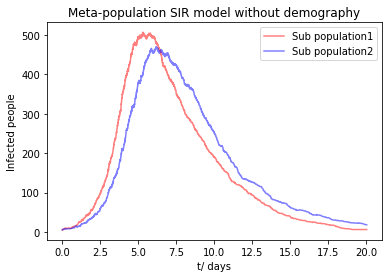

In [11]:
# Build metapopulation SIR model as class

class SIR_meta(object):

    # Set the initial parameters
    def __init__(self, S0, I0, R0, beta, gamma, rho, t_stop):
        self.S, self.I, self.R, self.N, self.t, self.lambd, self.rate_i, self.rate_r = [], [], [], [], [], [], [], []
        for i in range(len(S0)):
            self.S.append([S0[i]]),self.I.append([I0[i]]),self.R.append([R0[i]])
            self.N.append([S0[i] + I0[i] + R0[i]])
            self.lambd.append(0)
            self.rate_i.append(0)
            self.rate_r.append(0)
        self.t.append(0)
    
    # Simulate random events happening
    def events(self):
        while self.t[-1] < t_stop:
            SIR_meta.total_population(self)
            SIR_meta.create_lambda(self)
            rate_i, rate_r, rate_total = SIR_meta.rates(self)

            if rate_total == 0:
                break
            ran1, ran2 = np.random.uniform(0,1), np.random.uniform(0,1) * rate_total
            t_step = -math.log(ran1) / rate_total
            self.t.append(self.t[-1] + t_step)

            if ran2 < rate_i[0]:
                # Event 1: Group1 infection 
                SIR_meta.events_stay(self)
                self.S[0][-1] -= 1 
                self.I[0][-1] += 1
            elif ran2 < rate_i[0] + rate_i[1]:
                # Event 2: Group2 infection         
                SIR_meta.events_stay(self)
                self.S[1][-1] -= 1 
                self.I[1][-1] += 1
            elif ran2 < rate_i[0] + rate_i[1] + rate_r[0]:
                # Event 3: Group1 recovery
                SIR_meta.events_stay(self)
                self.I[0][-1] -= 1 
                self.R[0][-1] += 1
            else:
                # Event 4: Group2 recovery
                SIR_meta.events_stay(self)
                self.I[1][-1] -= 1 
                self.R[1][-1] += 1

        return [self.t,self.S,self.I,self.R]

    def total_population(self):
        for i in range(len(S0)):
            self.N[i].append(self.S[i][-1]+self.I[i][-1]+self.R[i][-1])

    def create_lambda(self):
        for i in range(len(S0)):
            value = 0
            for j in range(len(S0)):
                value = value + beta * rho[i][j] * self.I[j][-1] / self.N[i][-1]
            self.lambd[i] = value
        
    def rates(self):
        rate_total = 0
        for i in range(len(S0)):
            self.rate_i[i] = self.lambd[i] * self.S[i][-1] 
            self.rate_r[i] = gamma * self.I[i][-1]
            rate_total = rate_total + self.rate_i[i] + self.rate_r[i]
        return self.rate_i, self.rate_r, rate_total

    def events_stay(self):
        for i in range(len(S0)):      
            self.S[i].append(self.S[i][-1])
            self.I[i].append(self.I[i][-1])
            self.R[i].append(self.R[i][-1])

# Set the initial values
S0 = [995, 995]
I0 = [5, 5]
R0 = [0, 0]

beta = 1.4
gamma = 0.3
rho = [[1, 0.3],[0, 1]]
t_stop = 20

# Operate class function
results = SIR_meta(S0, I0, R0, beta, gamma, rho, t_stop).events()

# Plot basic SIR model
plt.plot(results[0], results[2][0], c = "r", alpha = 0.5, label = "Sub population1")
plt.plot(results[0], results[2][1], c = "b", alpha = 0.5, label = "Sub population2")
plt.legend()
plt.xlabel("t/ days")
plt.ylabel("Infected people")
plt.title("Meta-population SIR model without demography")
plt.show()

### 2.1.2 Test the impact of different $\rho$ on sub population 1:

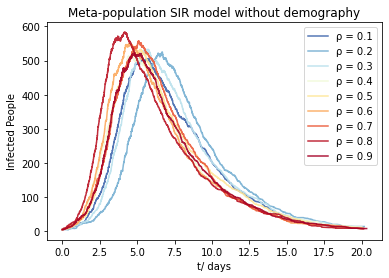

In [12]:
# Set the initial values
S0 = [995, 995]
I0 = [5, 5]
R0 = [0, 0]

beta = 1.4
gamma = 0.3
rho = [[1, 0], [0, 1]]
rho_list = np.linspace(0.1, 0.9, 9)
t_stop = 20

# Adjust the line color
def  Color_Normalization(x,inp_list):
    x=x/np.average(inp_list)
    return x/16

# Operate class function
for i in range(len(rho_list)):
    rho[0][1] = rho_list[i]
    results = SIR_meta(S0, I0, R0, beta, gamma, rho, t_stop).events()
    plt.plot(results[0], results[2][0], alpha = 0.9, color = plt.cm.RdYlBu(0.92-Color_Normalization(i,rho_list)), label = chr(961) + ' = '+str(round(rho_list[i],2)))

plt.legend()
plt.xlabel("t/ days")
plt.ylabel("Infected People")
plt.title("Meta-population SIR model without demography")
plt.show()

### 2.1.2 Explore the delays and peak heights between two sub populations:

Use Pearson correlation coefficient analysis: caculate correlation coefficient and significance level (P-value).

For correlation coefficient:
| correlation | Negative | Positive |
| :--- | :---: | :--- |
| None | -0.09 to 0.0 | 0.0 to 0.09 |
| Weak | -0.3 to -0.1 | 0.1 to 0.3 |
| Medium | -0.5 to -0.3 | 0.3 to 0.5 |
| Strong | -1.0 to -0.5 | 0.5 to 1.0 |

For significance level:
If P-value is lower than the conventional 5% (P<0.05) the correlation coefficient is called statistically significant. If it is less than 0.01, it is more significant; for example, p value = 0.001, which is a very high significance level.

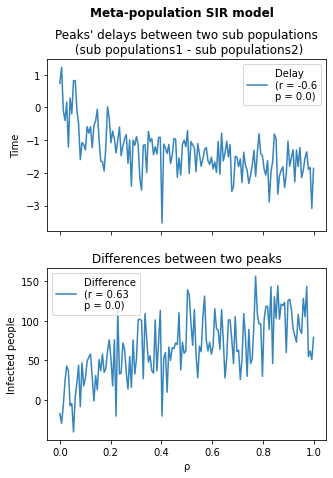

In [13]:
# Set the initial values
S0 = [995, 995]
I0 = [5, 5]
R0 = [0, 0]
beta = 1.4
gamma = 0.3
rho = [[1, 0], [0, 1]]
rho_list = np.linspace(0, 1, 150)
t_stop = 20
delays = []
heights = []

# Find the peaks and delays
fig,ax = plt.subplots(nrows = 2,ncols = 1,sharex=True,figsize=(5,7))
for i in range(len(rho_list)):
    rho[0][1] = rho_list[i]
    results = SIR_meta(S0, I0, R0, beta, gamma, rho, t_stop).events()
    peak1_index = results[2][0].index(max(results[2][0]))
    peak2_index = results[2][1].index(max(results[2][1]))
    delay = results[0][peak1_index] - results[0][peak2_index]
    height = results[2][0][peak1_index] - results[2][1][peak2_index]
    delays.append(delay)
    heights.append(height)

# Caculate correlation coefficient (r) and significance level (p)
r1, p1 = stats.pearsonr(rho_list, delays)   
r2, p2 = stats.pearsonr(rho_list, heights)  

# Plot data
ax[0].figsize=(5,4) 
ax[1].figsize=(5,4) 
ax[0].plot(rho_list, delays, '-', alpha = 0.9, label = 'Delay' + '\n' + '(r = '+ str(round(r1, 2))+'\n'+'p = ' + str(round(p1, 2)) + ')')
ax[1].plot(rho_list, heights, '-', alpha = 0.9, label = 'Difference' + '\n' + '(r = '+ str(round(r2, 2))+'\n'+'p = ' + str(round(p2, 2)) + ')')
ax[0].set_title("Peaks' delays between two sub populations" + '\n' + " (" + 'sub populations1 - sub populations2' + ")")
ax[1].set_title('Differences between two peaks')
ax[1].set_xlabel(chr(961))
ax[0].set_ylabel('Time')
ax[1].set_ylabel('Infected people')
ax[0].legend(loc = 'upper right', fontsize = 10)
ax[1].legend(loc = 'upper left', fontsize = 10)
fig.subplots_adjust(hspace = 0.22)
fig.suptitle('Meta-population SIR model', y= 0.985, weight='bold', fontsize=12)
plt.show()

### 2.1.3 More sub populations

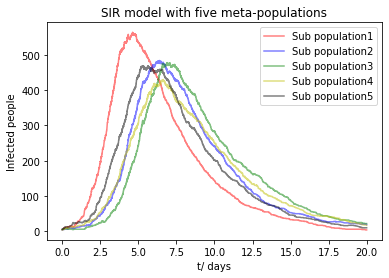

In [14]:
class SIR_meta(object):

    # Set the initial parameters
    def __init__(self, S0, I0, R0, beta, gamma, rho, t_stop):
        self.S, self.I, self.R, self.N, self.t, self.lambd, self.rate_i, self.rate_r = [], [], [], [], [], [], [], []
        for i in range(len(S0)):
            self.S.append([S0[i]]),self.I.append([I0[i]]),self.R.append([R0[i]])
            self.N.append([S0[i] + I0[i] + R0[i]])
            self.lambd.append(0)
            self.rate_i.append(0)
            self.rate_r.append(0)
        self.t.append(0)
    
    # Simulate random events happening
    def events(self):
        while self.t[-1] < t_stop:
            SIR_meta.total_population(self)
            SIR_meta.create_lambda(self)
            rate_i, rate_r, rate_total = SIR_meta.rates(self)

            if rate_total == 0:
                break
            ran1, ran2 = np.random.uniform(0,1), np.random.uniform(0,1) * rate_total
            t_step = -math.log(ran1) / rate_total
            self.t.append(self.t[-1] + t_step)

            if ran2 < rate_i[0]:
                # Event 1: Group1 infection 
                SIR_meta.events_stay(self)
                self.S[0][-1] -= 1 
                self.I[0][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0]:
                # Event 2: Group1 recovery        
                SIR_meta.events_stay(self)
                self.I[0][-1] -= 1 
                self.R[0][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1]:
                # Event 3: Group2 infection
                SIR_meta.events_stay(self)
                self.S[1][-1] -= 1 
                self.I[1][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1] + rate_r[1]:
                # Event 4: Group2 recovery
                SIR_meta.events_stay(self)
                self.I[1][-1] -= 1 
                self.R[1][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1] + rate_r[1] + rate_i[2]:
                # Event 5: Group3 infection
                SIR_meta.events_stay(self)
                self.S[2][-1] -= 1 
                self.I[2][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1] + rate_r[1] + rate_i[2] + rate_r[2]:
                # Event 6: Group3 recovery
                SIR_meta.events_stay(self)
                self.I[2][-1] -= 1 
                self.R[2][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1] + rate_r[1] + rate_i[2] + rate_r[2] + rate_i[3]:
                # Event 7: Group4 infection
                SIR_meta.events_stay(self)
                self.S[3][-1] -= 1 
                self.I[3][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1] + rate_r[1] + rate_i[2] + rate_r[2] + rate_i[3] + rate_r[3]:
                # Event 8: Group4 recovery
                SIR_meta.events_stay(self)
                self.I[3][-1] -= 1 
                self.R[3][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1] + rate_r[1] + rate_i[2] + rate_r[2] + rate_i[3] + rate_r[3] + rate_i[4]:
                # Event 9: Group5 infection
                SIR_meta.events_stay(self)
                self.S[4][-1] -= 1 
                self.I[4][-1] += 1
            else:
                # Event 10: Group5 recovery
                SIR_meta.events_stay(self)
                self.I[4][-1] -= 1 
                self.R[4][-1] += 1

        return [self.t,self.S,self.I,self.R]

    def total_population(self):
        for i in range(len(S0)):
            self.N[i].append(self.S[i][-1]+self.I[i][-1]+self.R[i][-1])

    def create_lambda(self):
        for i in range(len(S0)):
            value = 0
            for j in range(len(S0)):
                value = value + beta * rho[i][j] * self.I[j][-1] / self.N[i][-1]
            self.lambd[i] = value
        
    def rates(self):
        rate_total = 0
        for i in range(len(S0)):
            self.rate_i[i] = self.lambd[i] * self.S[i][-1] 
            self.rate_r[i] = gamma * self.I[i][-1]
            rate_total = rate_total + self.rate_i[i] + self.rate_r[i]
        return self.rate_i, self.rate_r, rate_total

    def events_stay(self):
        for i in range(len(S0)):      
            self.S[i].append(self.S[i][-1])
            self.I[i].append(self.I[i][-1])
            self.R[i].append(self.R[i][-1])

# Set the initial values
S0 = [995, 995, 995, 995, 995]
I0 = [5, 5, 5, 5, 5]
R0 = [0, 0, 0, 0, 0]
beta = 1.4
gamma = 0.3
rho = [[1, 0.15, 0.18, 0.2, 0.34], 
[0, 1, 0, 0, 0], 
[0, 0, 1, 0, 0], 
[0, 0, 0, 1, 0], 
[0, 0, 0, 0, 1]]
t_stop = 20

# Operate class function
results = SIR_meta(S0, I0, R0, beta, gamma, rho, t_stop).events()

# Plot basic SIR model
plt.plot(results[0], results[2][0], c = "r", alpha = 0.5, label = "Sub population1")
plt.plot(results[0], results[2][1], c = "b", alpha = 0.5, label = "Sub population2")
plt.plot(results[0], results[2][2], c = "g", alpha = 0.5, label = "Sub population3")
plt.plot(results[0], results[2][3], c = "y", alpha = 0.5, label = "Sub population4")
plt.plot(results[0], results[2][4], c = "black", alpha = 0.5, label = "Sub population5")
plt.legend()
plt.xlabel("t/ days")
plt.ylabel("Infected people")
plt.title("SIR model with five meta-populations")
plt.show()

## 2.2 Network model and Vaccines
### 2.2.1 Assess the impact of the epidemic:

All models of NDlib assume an agent-based, discrete-time, simulation engine.
During each iteration all the nodes in the network are asked to

1. Evaluate their current status and to
2. (eventually) apply a matching transition rule. So, the higher the degree of a node, the more likely that it becomes infected.

<br>``Ndlib`` breaks the simulation of diffusive phenomena into a standard workflow:
- Network Creation
- Diffusion model Selection
- Simulation execution
- Results visualisation


References: 

G. Rossetti, L. Milli, S. Rinzivillo, A. Sirbu, D. Pedreschi, F. Giannotti. “NDlib: a Python Library to Model and Analyze Diffusion Processes Over Complex Networks” Journal of Data Science and Analytics. 2017. DOI:0.1007/s41060-017-0086-6 (pre-print available on arXiv)

G. Rossetti, L. Milli, S. Rinzivillo, A. Sirbu, D. Pedreschi, F. Giannotti. “NDlib: Studying Network Diffusion Dynamics” IEEE International Conference on Data Science and Advanced Analytics, DSAA. 2017.

In [15]:
class Network_SIRmodel(object):

    # Set the initial parameters
    def __init__(self, g, graph_name, beta, gamma, End_day):
        self.g = g
        self.beta = beta
        self.gamma = gamma
        self.color_dict = {'S':'b', 'I':'r', 'R':'g'} 
        
    # Update the condition of single node
    def update_node(self, node):
        R = np.random.uniform(0,1)              # Generate a ramdom number R from 0 to 1
        if self.g.nodes[node]['state'] == 'S': 
            # Condition1: Susceptible
            neighbors_infected = 0        # Count how many neighbors infected
            for i in self.g.adj[node]: 
                if self.g.nodes[i]['state'] == 'I': 
                    neighbors_infected += 1
            if R < 1 - (1 - beta)**neighbors_infected:  # This node: S -> I
                self.g.nodes[node]['state'] = 'I'  
        elif self.g.nodes[node]['state'] == 'I':  
            # Condition2: Infected
            if R < gamma:   
                self.g.nodes[node]['state'] = 'R' 
        
    # Update the whole network
    def update_network(self):
        for node in self.g: 
            Network_SIRmodel.update_node(self, node)  
       
    # Count the total number of S, I , and R
    def count(self):
        self.S = 0; self.I = 0; self.R = 0
        for node in self.g:
            if self.g.nodes[node]['state'] == 'S':
                self.S += 1
            elif self.g.nodes[node]['state'] == 'I':
                self.I += 1
            else :
                self.R += 1
        return [self.S, self.I, self.R]   

    # Adjust the node color
    def node_color(self):   
        self.color_list = []  
        for node in self.g:
            self.color_list.append(self.color_dict[self.g.nodes[node]['state']])
        return self.color_list  

    # Caculate all results of SIR dynamics
    def dynamics(self):
        # Count the initial number of SIR
        results = []
        results.append(G.count())
        for t in range(0, End_day):
            G.update_network()           # Update network
            results.append(G.count())    # Count S, I, and R number
        return results

    # Draw nines graphs happened evenly in whole process, and give the data of SIR dynamics
    def draw_graphs(self):
        # Count the initial number of SIR
        results = []
        results.append(G.count())
        fig, ax= plt.subplots(3, 3,figsize=(18, 18))
        for t in range(0, End_day):
            # Plot nine graphs as even time interval through the whole period
            if int(t% (End_day / 7)) == 0:
                plt.subplot(331 + int(t / (End_day / 7)))
                plt.title('Day: ' + str(t), fontsize = 17)
                nx.draw(g, with_labels = False, font_color='white', alpha = 0.6,node_color = G.node_color(), edge_color = 'gray')
            elif int(t) == int(End_day-1):
                plt.subplot(338)
                plt.title('Day: ' + str(t+1), fontsize = 17)
                nx.draw(g, with_labels = False, font_color='white', alpha = 0.6,node_color = G.node_color(), edge_color = 'gray')
            G.update_network()           # Update network
            results.append(G.count())    # Count S, I, and R number
        
        # Adjust the whole image
        plt.suptitle('Network dynamic: ' + graph_name, y=0.95, weight='bold', fontsize=22)
        
        return results

#### 2.1.1.1 Scale-free networks: Barabasi Albert graph

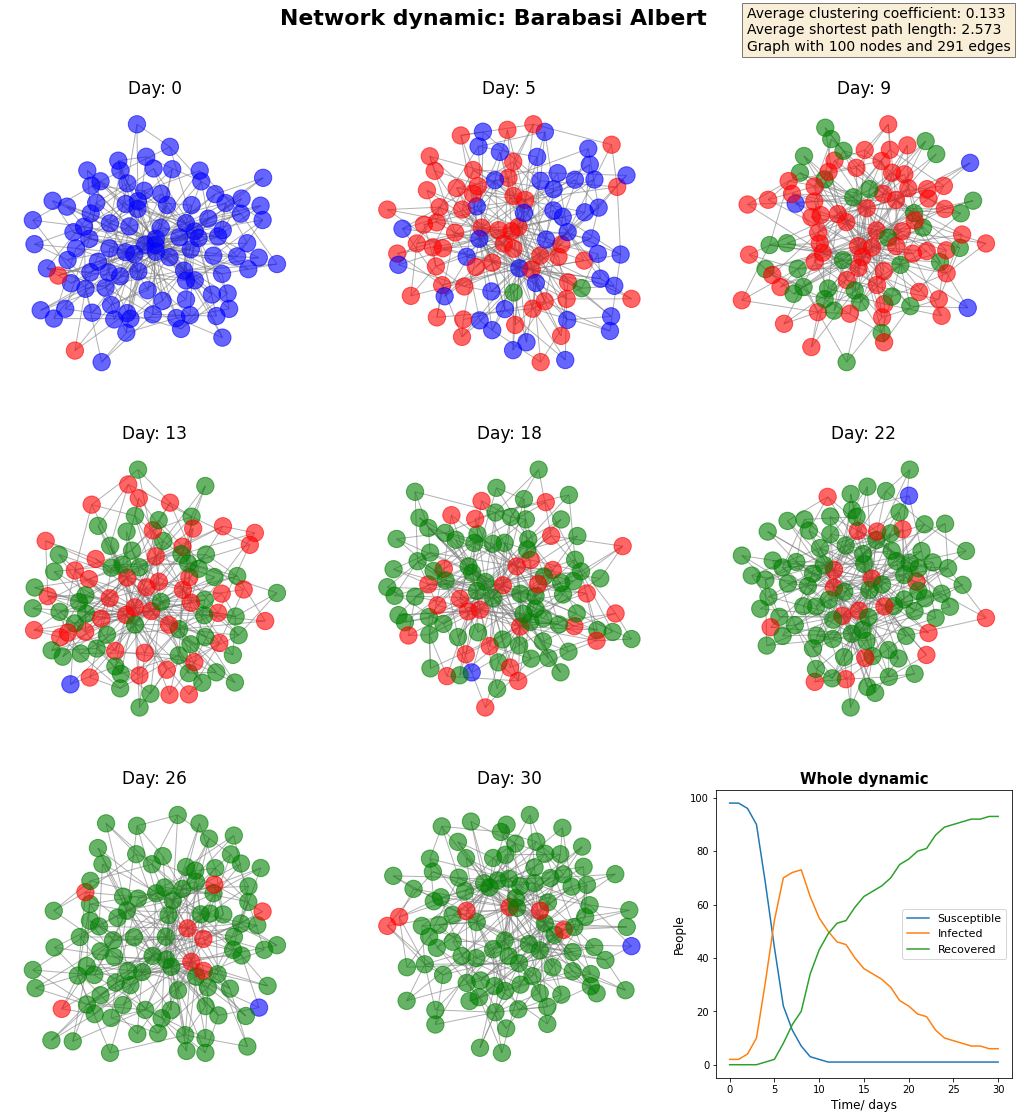

In [16]:
# Set the initial values
N = 100
beta = 0.2
gamma = 0.1
End_day = 30
# Scale-free networks: more vulnerable to attacks 
graph_name = 'Barabasi Albert'
g = nx.barabasi_albert_graph(N, 3, seed=2) 
# pos = nx.random_layout(g, seed = 26) 

# Set the condition for every node, and import the infected
for node in g:   
    g.nodes[node]['state'] = 'S'
R1 = int(np.random.uniform(0,100))
R2 = int(np.random.uniform(0,100))
g.nodes[R1]['state'] = "I"     # Set infectious node
g.nodes[R2]['state'] = 'I'

# Put the graph into class
G = Network_SIRmodel(g, graph_name, beta, gamma, End_day)

# Generate graphs and every steps dynamics data
results = G.draw_graphs()

# Analyse the trend dynamics
color_dict = {'S':'b','I':'r','R':'g'} 
count = pd.DataFrame(results,columns=['S', 'I', 'R'])
plt.subplot(3,3,9)
plt.plot(count)
plt.title('Whole dynamic',weight='bold', fontsize = 15)
plt.xlabel('Time/ days', fontsize=12)
plt.ylabel('People', fontsize=12)
plt.legend(labels=['Susceptible','Infected','Recovered','True cases'],loc="right",fontsize=11)
plt.text(1.9, 380, 'Average clustering coefficient: '+ str(round(nx.average_clustering(g), 3)) + '\n' + 'Average shortest path length: ' + str(round(nx.average_shortest_path_length(g), 3)) + '\n' + nx.info(g), bbox=dict(boxstyle="square", facecolor='wheat', edgecolor='black', alpha= 0.5),fontsize=14)
plt.show()

#### 2.1.1.2 Small World Networks: Watts-Strogatz graph

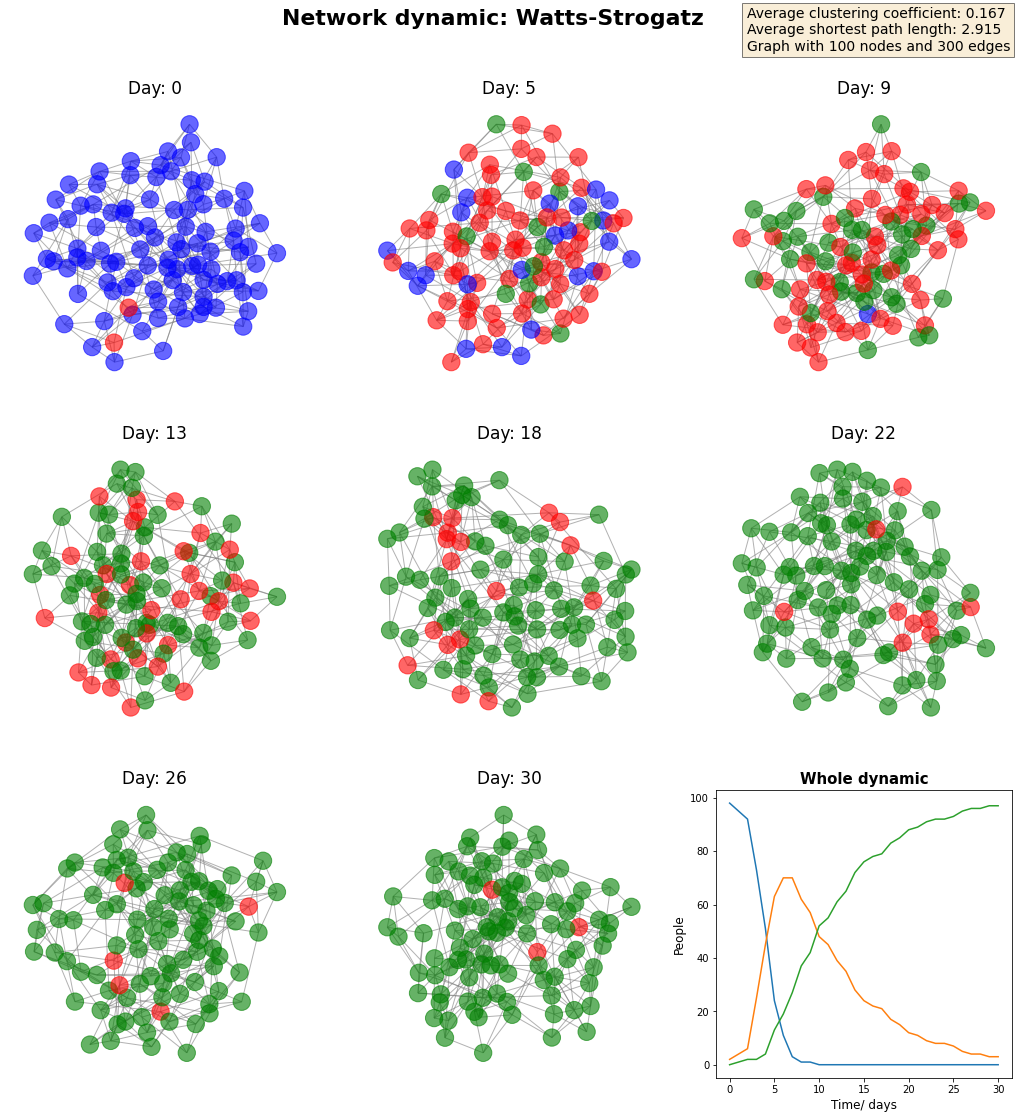

In [17]:
# Set the initial values
N = 100
beta = 0.2
gamma = 0.1
End_day = 30
#  Small World Networks
graph_name = 'Watts-Strogatz'
g = nx.watts_strogatz_graph(N, 6, 0.4, seed=2) 
# pos = nx.random_layout(g, seed = 26) 

# Set the condition for every node, and import the infected
for node in g:   
    g.nodes[node]['state'] = 'S'
R1 = int(np.random.uniform(0,100))
R2 = int(np.random.uniform(0,100))
g.nodes[R1]['state'] = "I"     # Set infectious node
g.nodes[R2]['state'] = 'I'

# Put the graph into class
G = Network_SIRmodel(g, graph_name, beta, gamma, End_day)

# Generate graphs and every steps dynamics data
results = G.draw_graphs()

# Analyse the trend dynamics
color_dict = {'S':'b','I':'r','R':'g'} 
count = pd.DataFrame(results,columns=['S', 'I', 'R'])
plt.subplot(3,3,9)
plt.plot(count)
plt.title('Whole dynamic',weight='bold', fontsize = 15)
plt.xlabel('Time/ days', fontsize=12)
plt.ylabel('People', fontsize=12)
plt.text(1.9, 380, 'Average clustering coefficient: '+ str(round(nx.average_clustering(g), 3)) + '\n' + 'Average shortest path length: ' + str(round(nx.average_shortest_path_length(g), 3)) + '\n' + nx.info(g), bbox=dict(boxstyle="square", facecolor='wheat', edgecolor='black', alpha= 0.5),fontsize=14)
plt.show()

In [18]:
#### 2.1.1.3 Random Networks: Erdos-Reyni graph

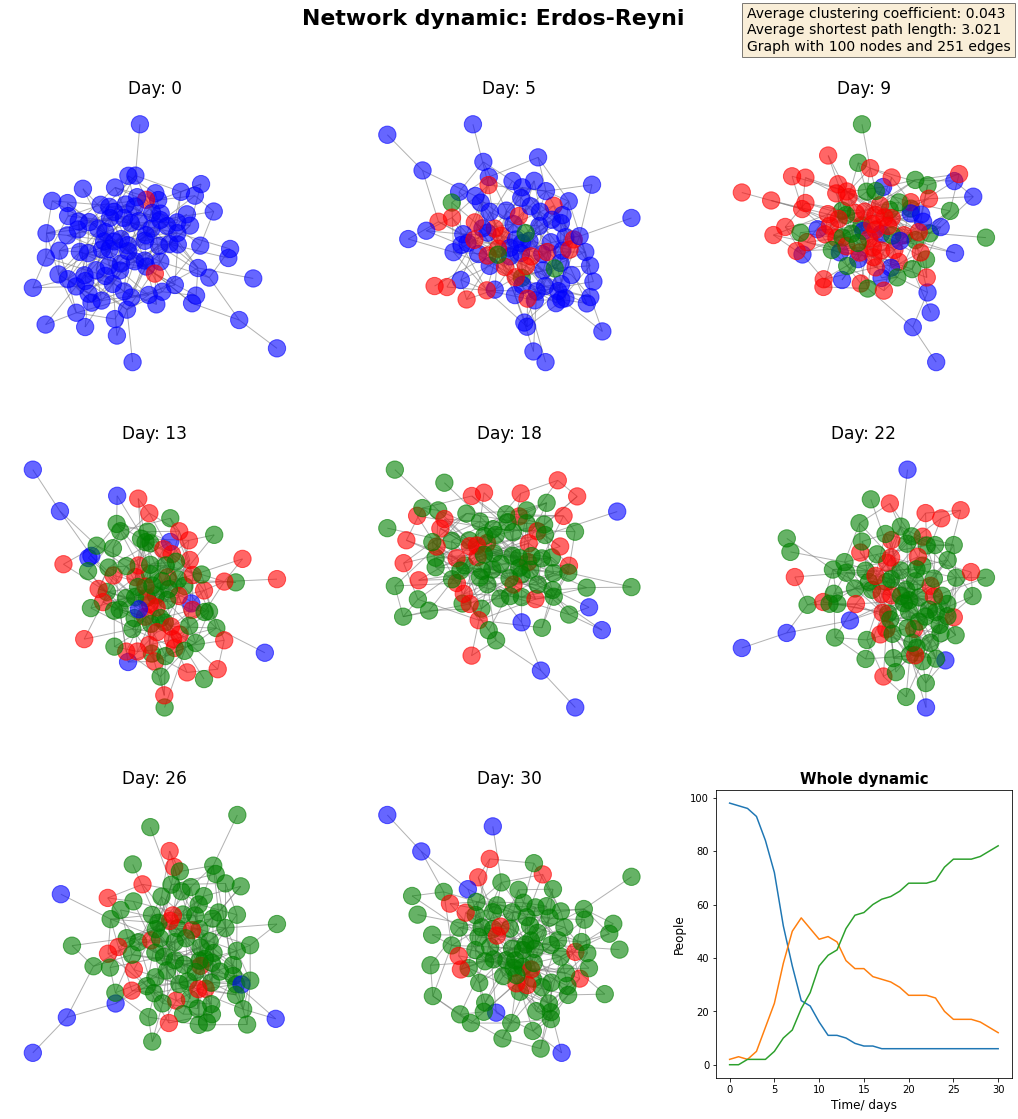

In [19]:
# Set the initial values
N = 100
beta = 0.2
gamma = 0.1
End_day = 30
graph_name = 'Erdos-Reyni'
# Random Networks: a random graph with N labeled nodes where each pair of nodes is connected by a preset probability p. The random network is therefore characterized by a lack of heterogeneity in the number of contacts and a lack of clustering.
g = nx.erdos_renyi_graph(N, 0.05, seed=2)  


# Set the condition for every node, and import the infected
for node in g:   
    g.nodes[node]['state'] = 'S'
R1 = int(np.random.uniform(0,100))
R2 = int(np.random.uniform(0,100))
g.nodes[R1]['state'] = "I"     # Set infectious node
g.nodes[R2]['state'] = 'I'

# Put the graph into class
G = Network_SIRmodel(g, graph_name, beta, gamma, End_day)

# Generate graphs and every steps dynamics data
results = G.draw_graphs()

# Analyse the trend dynamics
color_dict = {'S':'b','I':'r','R':'g'} 
count = pd.DataFrame(results,columns=['S', 'I', 'R'])
plt.subplot(3,3,9)
plt.plot(count)
plt.title('Whole dynamic',weight='bold', fontsize = 15)
plt.xlabel('Time/ days', fontsize=12)
plt.ylabel('People', fontsize=12)
plt.text(1.9, 380, 'Average clustering coefficient: '+ str(round(nx.average_clustering(g), 3)) + '\n' + 'Average shortest path length: ' + str(round(nx.average_shortest_path_length(g), 3)) + '\n' + nx.info(g), bbox=dict(boxstyle="square", facecolor='wheat', edgecolor='black', alpha= 0.5),fontsize=14)
plt.show()

### 2.2.2 Vary disease initalisation:

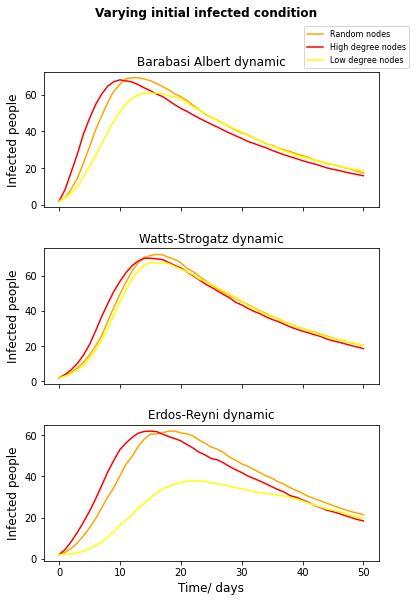

In [20]:
# Because the initial infectecd has the crucial influence on epidemic, we can vary the initial infected node on networks

# Set the initial values
N = 100
beta = 0.1
gamma = 0.04
End_day = 50
times = 30
graph_name1 = 'Barabasi Albert'
graph_name2 = 'Watts-Strogatz'
graph_name3 = 'Erdos-Reyni'

"1"""""""""""""""""""
########  Simulate multiple times random results and caculate the average trend ##########
results1 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random1) 

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name1, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results1 = results1.add(results)
results1['I'] = results1['I'] / times
###########################################################

########  Simulate multiple times highest results and caculate the average trend ########
results2 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random) 

    # Find the node with the highest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)
    # print(nodes_degree[0:5].to_string(index = False))

    # Set the node with the highest and second highest degree as the infected
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_highest]['state'] = 'I'
    g.nodes[node_second_highest]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name1, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results2 = results2.add(results)
results2['I'] = results2['I'] / times
###########################################################

########  Simulate multiple times lowest results and caculate the average trend ########
results3 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random) 

    # Find the node with the lowest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the node with the lowest and second lowest degree as the infected
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_lowest]['state'] = 'I'
    g.nodes[node_second_lowest]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name1, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results3 = results3.add(results)
results3['I'] = results3['I'] / times
###########################################################

"2"""""""""""""""""""""""""""""""""""""""""""

########  Simulate multiple times random results and caculate the average trend ##########
results4 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4, seed = seed_random1) 

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name2, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results4 = results4.add(results)
results4['I'] = results4['I'] / times
###########################################################

########  Simulate multiple times highest results and caculate the average trend ########
results5 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4, seed = seed_random) 

    # Find the node with the highest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)
    # print(nodes_degree[0:5].to_string(index = False))

    # Set the node with the highest and second highest degree as the infected
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_highest]['state'] = 'I'
    g.nodes[node_second_highest]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name2, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results5 = results5.add(results)
results5['I'] = results5['I'] / times
###########################################################

########  Simulate multiple times lowest results and caculate the average trend ########
results6 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4, seed = seed_random) 

    # Find the node with the lowest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the node with the lowest and second lowest degree as the infected
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_lowest]['state'] = 'I'
    g.nodes[node_second_lowest]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name2, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results6 = results6.add(results)
results6['I'] = results6['I'] / times
###########################################################

"3"""""""""""""""""""""""""""""""""""""""""""

########  Simulate multiple times random results and caculate the average trend ##########
results7 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random1) 
    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name3, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results7 = results7.add(results)
results7['I'] = results7['I'] / times
###########################################################

########  Simulate multiple times highest results and caculate the average trend ########
results8 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N) 
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random) 
    # Find the node with the highest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)
    # print(nodes_degree[0:5].to_string(index = False))

    # Set the node with the highest and second highest degree as the infected
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_highest]['state'] = 'I'
    g.nodes[node_second_highest]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name3, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results8 = results8.add(results)
results8['I'] = results8['I'] / times
###########################################################

########  Simulate multiple times lowest results and caculate the average trend ########
results9 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random) 

    # Find the node with the lowest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the node with the lowest and second lowest degree as the infected
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_lowest]['state'] = 'I'
    g.nodes[node_second_lowest]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name3, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results9 = results9.add(results)
results9['I'] = results9['I'] / times
###########################################################

# Analyse the trend dynamics
fig, ax = plt.subplots(nrows = 3, ncols = 1, sharex=True, figsize=(6,9))

ax[0].plot(results1['I'], color = 'orange', label = 'Random nodes')
ax[0].plot(results2['I'], color = 'red', label = 'High degree nodes')
ax[0].plot(results3['I'], color = 'yellow', label = 'Low degree nodes')
ax[0].set_title('Barabasi Albert dynamic')
ax[0].set_ylabel('Infected people', fontsize = 12)
ax[1].plot(results4['I'], color = 'orange')
ax[1].plot(results5['I'], color = 'red')
ax[1].plot(results6['I'], color = 'yellow')
ax[1].set_title('Watts-Strogatz dynamic')
ax[1].set_ylabel('Infected people', fontsize = 12)
ax[2].plot(results7['I'], color = 'orange')
ax[2].plot(results8['I'], color = 'red')
ax[2].plot(results9['I'], color = 'yellow')
ax[2].set_title('Erdos-Reyni dynamic')
ax[2].set_ylabel('Infected people', fontsize = 12)

fig.suptitle('Varying initial infected condition', weight='bold')
plt.xlabel('Time/ days', fontsize = 12)
plt.subplots_adjust(hspace=0.3,wspace=0.2)
fig.legend(loc = 'upper right', borderaxespad = 0, bbox_to_anchor=( 0.97, 0.95),fontsize = 8)
plt.show()

### 2.2.3 Vaccine strategy:

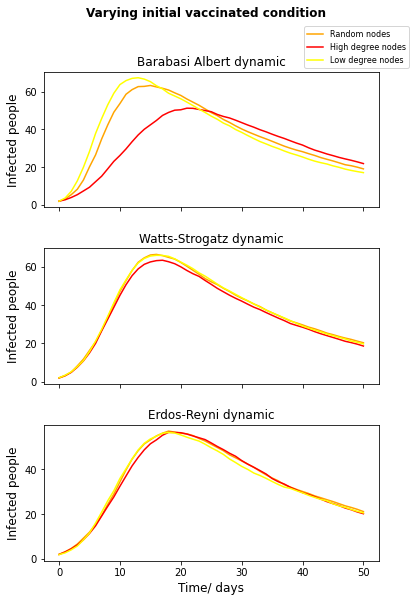

In [21]:
# Select the nodes with four random, highest degree, and lowest degree as initial vaccinated respectively. And import two infection randomly.

# Set the initial values
N = 100
beta = 0.1
gamma = 0.04
End_day = 50
times = 50
graph_name1 = 'Barabasi Albert'
graph_name2 = 'Watts-Strogatz'
graph_name3 = 'Erdos-Reyni'

"1"""""""""""""""""""
########  Simulate multiple times random results and caculate the average trend ##########
results1 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    seed_random4 = np.random.randint(0, N)
    seed_random5 = np.random.randint(0, N)
    seed_random6 = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random1) 

    # Set the condition for every node, import the infected, and vaccinate
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'R'
    g.nodes[seed_random4]['state'] = 'R'
    g.nodes[seed_random5]['state'] = 'R'
    g.nodes[seed_random6]['state'] = 'R'
    
    # Put the graph into class
    G = Network_SIRmodel(g, graph_name1, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results1 = results1.add(results)
results1['I'] = results1['I'] / times
###########################################################

########  Simulate multiple times highest results and caculate the average trend ########
results2 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random1) 

    # Find the node with the highest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)
    # print(nodes_degree[0:5].to_string(index = False))

    # Set the node with the highest and second highest degree as the recovered
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])
    node_third_highest = int(nodes_degree.values[2,0])
    node_fourth_highest = int(nodes_degree.values[3,0])

    # Set the condition for every node, import the infected, and vaccinate the nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_highest]['state'] = 'R'
    g.nodes[node_second_highest]['state'] = 'R'
    g.nodes[node_third_highest]['state'] = 'R'
    g.nodes[node_fourth_highest]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name1, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results2 = results2.add(results)
results2['I'] = results2['I'] / times
###########################################################

########  Simulate multiple times lowest results and caculate the average trend ########
results3 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random1) 

    # Find the node with the lowest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the node with the lowest and second lowest degree as the recovered
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])
    node_third_lowest = int(nodes_degree.values[2,0])
    node_fourth_lowest = int(nodes_degree.values[3,0])

    # Set the condition for every node, import the infected, and vaccinate the nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_lowest]['state'] = 'R'
    g.nodes[node_second_lowest]['state'] = 'R'
    g.nodes[node_third_lowest]['state'] = 'R'
    g.nodes[node_fourth_lowest]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name1, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results3 = results3.add(results)
results3['I'] = results3['I'] / times
###########################################################

"2"""""""""""""""""""""""""""""""""""""""""""

########  Simulate multiple times random results and caculate the average trend ##########
results4 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    seed_random4 = np.random.randint(0, N)
    seed_random5 = np.random.randint(0, N)
    seed_random6 = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4, seed = seed_random1) 

    # Set the condition for every node, import the infected, and vaccinate
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'R'
    g.nodes[seed_random4]['state'] = 'R'
    g.nodes[seed_random5]['state'] = 'R'
    g.nodes[seed_random6]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name2, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results4 = results4.add(results)
results4['I'] = results4['I'] / times
###########################################################

########  Simulate multiple times highest results and caculate the average trend ########
results5 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4, seed = seed_random1) 

    # Find the node with the highest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)
    # print(nodes_degree[0:5].to_string(index = False))

    # Set the node with the highest and second highest degree as the infected
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])
    node_third_highest = int(nodes_degree.values[2,0])
    node_fourth_highest = int(nodes_degree.values[3,0])

    # Set the condition for every node, import the infected, and vaccinate the nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_highest]['state'] = 'R'
    g.nodes[node_second_highest]['state'] = 'R'
    g.nodes[node_third_highest]['state'] = 'R'
    g.nodes[node_fourth_highest]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name2, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results5 = results5.add(results)
results5['I'] = results5['I'] / times
###########################################################

########  Simulate multiple times lowest results and caculate the average trend ########
results6 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4, seed = seed_random) 

    # Find the node with the lowest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the node with the lowest and second lowest degree as the infected
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])
    node_third_lowest = int(nodes_degree.values[2,0])
    node_fourth_lowest = int(nodes_degree.values[3,0])

    # Set the condition for every node, import the infected, and vaccinate the nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_lowest]['state'] = 'R'
    g.nodes[node_second_lowest]['state'] = 'R'
    g.nodes[node_third_lowest]['state'] = 'R'
    g.nodes[node_fourth_lowest]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name2, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results6 = results6.add(results)
results6['I'] = results6['I'] / times
###########################################################

"3"""""""""""""""""""""""""""""""""""""""""""

########  Simulate multiple times random results and caculate the average trend ##########
results7 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    seed_random4 = np.random.randint(0, N)
    seed_random5 = np.random.randint(0, N)
    seed_random6 = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random1) 
    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'R'
    g.nodes[seed_random4]['state'] = 'R'
    g.nodes[seed_random5]['state'] = 'R'
    g.nodes[seed_random6]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name3, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results7 = results7.add(results)
results7['I'] = results7['I'] / times
###########################################################

########  Simulate multiple times highest results and caculate the average trend ########
results8 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N) 
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random1) 
    # Find the node with the highest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)
    # print(nodes_degree[0:5].to_string(index = False))

    # Set the node with the highest and second highest degree as the infected
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])
    node_third_highest = int(nodes_degree.values[2,0])
    node_fourth_highest = int(nodes_degree.values[3,0])

    # Set the condition for every node, import the infected, and vaccinate the nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_highest]['state'] = 'R'
    g.nodes[node_second_highest]['state'] = 'R'
    g.nodes[node_third_highest]['state'] = 'R'
    g.nodes[node_fourth_highest]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name3, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results8 = results8.add(results)
results8['I'] = results8['I'] / times
###########################################################

########  Simulate multiple times lowest results and caculate the average trend ########
results9 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random) 

    # Find the node with the lowest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the node with the lowest and second lowest degree as the infected
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])
    node_third_lowest = int(nodes_degree.values[2,0])
    node_fourth_lowest = int(nodes_degree.values[3,0])

    # Set the condition for every node, import the infected, and vaccinate the nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_lowest]['state'] = 'R'
    g.nodes[node_second_lowest]['state'] = 'R'
    g.nodes[node_third_lowest]['state'] = 'R'
    g.nodes[node_fourth_lowest]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name3, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results9 = results9.add(results)
results9['I'] = results9['I'] / times
###########################################################

# Analyse the trend dynamics
fig, ax = plt.subplots(nrows = 3, ncols = 1, sharex=True, figsize=(6,9))

ax[0].plot(results1['I'], color = 'orange', label = 'Random nodes')
ax[0].plot(results2['I'], color = 'red', label = 'High degree nodes')
ax[0].plot(results3['I'], color = 'yellow', label = 'Low degree nodes')
ax[0].set_title('Barabasi Albert dynamic')
ax[0].set_ylabel('Infected people', fontsize = 12)
ax[1].plot(results4['I'], color = 'orange')
ax[1].plot(results5['I'], color = 'red')
ax[1].plot(results6['I'], color = 'yellow')
ax[1].set_title('Watts-Strogatz dynamic')
ax[1].set_ylabel('Infected people', fontsize = 12)
ax[2].plot(results7['I'], color = 'orange')
ax[2].plot(results8['I'], color = 'red')
ax[2].plot(results9['I'], color = 'yellow')
ax[2].set_title('Erdos-Reyni dynamic')
ax[2].set_ylabel('Infected people', fontsize = 12)

fig.suptitle('Varying initial vaccinated condition', weight='bold')
plt.xlabel('Time/ days', fontsize = 12)
plt.subplots_adjust(hspace=0.3,wspace=0.2)
fig.legend(loc = 'upper right', borderaxespad = 0, bbox_to_anchor=( 0.97, 0.95),fontsize = 8)
plt.show()

In [22]:
import numpy as np
import itertools
from functools import partial
import networkx as nx
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from ndlib.models import DiffusionModel
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import ndlib.models.dynamic as dm
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments as cp
import dynetx as dn
from pathlib import Path

from typing import Union, List, Dict, Tuple, Optional
from pprint import pprint
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

## Problem 1: Stochastic SIR

Explore the five hallmarks of stochastic SIR dynamics:
 - variability
 - negative co-variances
 - increased transients
 - stochastic resonance
 - and extinctions

Design a set of well chosen experiments to demonstrate all these aspects,also exploring the dependence on the basic parameters in the model.

The first step is creating a stochastic event based SIR model with support for demographic and imports using the **Gillespie’s discrete event model algorithm**.
At each time step, we compute the rates of all possible events, choose the closest one and advance the time.

In [23]:
class SIR_Demographic:
    def __init__(self, beta, gamma, mu=0.0, epsilon=0.0, i0=0.05, N_pop=1000):
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.epsilon = epsilon
        self.i0 = i0
        self.N_pop = N_pop
    
    def simulate(self, t_end=200):
        t = [0]
        I = [int(self.i0 * self.N_pop)]
        S = [self.N_pop - I[0]]
        R = [0]
        
        while t[-1] < float(t_end):
            N = S[-1] + I[-1] + R[-1]
            N = np.max([0.0001, N]) # avoid zero
            events = {
                "birth": self.mu * N,
                "transmission": self.beta * S[-1] * I[-1] / N,
                "recovery": self.gamma * I[-1],
                "death_susceptible": self.mu * S[-1],
                "death_infected": self.mu * I[-1],
                "death_recovered": self.mu * R[-1],
                "import": self.epsilon * S[-1],
            }
            events = {event: rate for event, rate in events.items() if rate > 0}
            if len(events) < 1:
                break
                
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1])
            
            # compute arrival times for each
            event_time = {
                event: -1.0/rate * np.log(np.random.uniform(0, 1))
                for event, rate in events.items()
            }
            
            # choose event that will occur next
            event, arrival = sorted(event_time.items(), key=lambda x: x[1])[0]
            
            if event == "birth":
                S[-1] += 1
            elif event == "transmission":
                S[-1] -= 1
                I[-1] += 1
            elif event == "recovery":
                I[-1] -= 1
                R[-1] += 1
            elif event == "death_susceptible":
                S[-1] -= 1
            elif event == "death_infected":
                I[-1] -= 1
            elif event == "death_recovered":
                R[-1] -= 1
            elif event == "import":
                S[-1] -= 1
                I[-1] += 1
            
            t.append(t[-1] + arrival)
        
        t = np.array(t)
        tt = np.linspace(0, t_end, t_end)
        Sip = interp1d(t, np.array(S), fill_value="extrapolate")
        Iip = interp1d(t, np.array(I), fill_value="extrapolate")
        Rip = interp1d(t, np.array(R), fill_value="extrapolate")
        result = np.array([Sip(tt), Iip(tt), Rip(tt)])
        return t, tt, result.T

We also will use a helper function to simulate a SIR experiment with a number of repetitions.

In [24]:
def simulate_sir_demography(
    beta=0.001, gamma=0.01, mu=0.0, epsilon=0.0, i0=0.05,
    N_pop=1000, t_end=200, repetitions=1,
):
    config = dict(
        beta=beta, gamma=gamma, mu=mu, epsilon=epsilon, i0=i0, N_pop=N_pop
    )
    model = SIR_Demographic(**config)
    ts, results = [], []
    for r in range(repetitions):
        _, t, result = model.simulate(t_end)
        ts.append(t)
        results.append(result)
        
    ts = np.vstack(ts).reshape(repetitions, t_end)
    results = np.vstack(results).reshape(repetitions, t_end, 3)
    return ts, results

Finally, we will use helper functions for plotting SIR simulations,
which will take care of computing the mean and std deviation from multiple runs.

In [25]:
def config_str(config, exclude=None):
    config = config or dict()
    exclude = exclude or []
    s = []
    conf = {k:v for k,v in config.items() if k not in exclude}
    handlers = dict(
        beta = lambda v: "$\\beta=$%.2e" % v,
        gamma = lambda v: "$\gamma=$%.2e" % v,
        mu = lambda v: "$\mu=$%.2e" % v,
        epsilon = lambda v: "$\epsilon=$%.2e" % v,
        i0 = lambda v: "$I_0=$%.2e" % v,
        I_0 = lambda v: "$I_0=$%.2e" % v,
        R_0 = lambda v: "$R_0=$%.2f" % v,
        N_pop = lambda v: "$N_{pop}=$%.1e" % v,
    )
    for k, v in conf.items():
        if k in handlers:
            s.append(handlers[k](v))
        else:
            s.append("%s=%.2e" % (k, v))
    return ", ".join(s)

DEFAULT_FONTSIZE = 13

def plot_sir(
    results,
    config,
    title=None,
    xlabel=None,
    ylabel=None,
    tightlayout=True,
    figsize=(6,4),
    fontsize=DEFAULT_FONTSIZE,
    confidence=True,
    confidence_scale=1.0,
    confidence_alpha=0.3,
):
    colors = {
        "susceptible": "blue",
        "infected": "red",
        "recovered": "green",
    }
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    for label, (t, result, options) in results.items():
        default_options = dict(
            label=label,
            color=colors.get(label.lower(), None),
        )
        options = {**default_options, **options}
        mean = result.mean(axis=0)
        ax.plot(t, mean, **options)
        if confidence and result.shape[0] > 1:
            std = result.std(axis=0)
            ax.fill_between(
                t,
                mean - std*confidence_scale,
                mean + std*confidence_scale,
                alpha=confidence_alpha,
                color=options.get("color"),
            )
    plt.ylabel(ylabel or "population", fontsize=fontsize)
    plt.xlabel(xlabel or "time $t$", fontsize=fontsize)
    plt.title(
        title or "SIR using Gillespie’s discrete event model\n(%s)" % (
            config_str(config)
        ),
        fontsize=fontsize
    )
    plt.legend(fontsize=fontsize)
    if tightlayout:
        plt.tight_layout()
    return fig, ax

#### Variability between simulations

It is generally impossible to predetermine the precise disease prevalence at any given point in the future.

This effect is especially pronounced in small populations, which we will show by running the same simulation 10 times on a population of size 40 and plotting the standard deviation for the number of susceptible, infected and recovered over these runs.

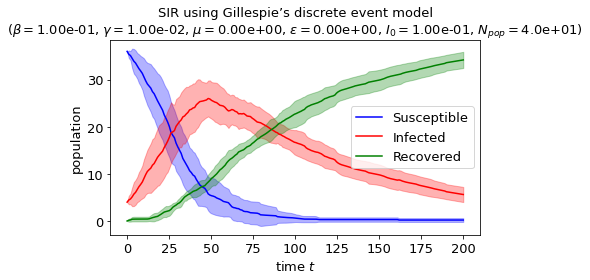

In [26]:
config = dict(
    beta=0.1, gamma=0.01, mu=0.0, epsilon=0.0, i0=0.1, N_pop=40
)
t, results = simulate_sir_demography(repetitions=10, **config)
fig, ax = plot_sir(
    {
        "Susceptible": (t.mean(axis=0), results[:,:,0], {}),
        "Infected": (t.mean(axis=0), results[:,:,1], {}),
        "Recovered":(t.mean(axis=0), results[:,:,2], {}),
    },
    config=config,
)
plt.show()

As hinted before, this effect is pronounced for smaller populations,
where the stochastic nature can lead to very different disease spread trajectories.
We show this by plotting the relative standard deviation of the number of infections 
for different population sizes $N_{pop}$ in the range $[40,500]$.
Here, we use 20 repetitions to reduce the effect of random variation.

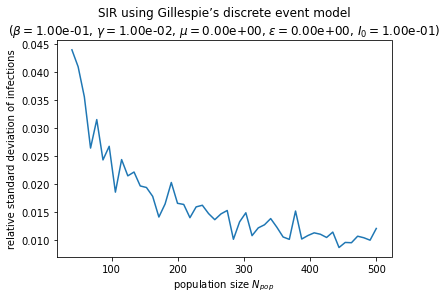

In [27]:
network_sizes = np.linspace(40,500,50)
per_network_size_results = []
for size in network_sizes:
    config = dict(
        beta=0.1, gamma=0.01, mu=0.0, epsilon=0.0, i0=0.1
    )
    t, results = simulate_sir_demography(
        repetitions=20, N_pop=size, **config)
    mean_std = (results[:,:,0] / size).std(axis=0).mean()
    per_network_size_results.append(mean_std)
    
per_network_size_results = np.array(per_network_size_results)
fig, ax = plt.subplots()
ax.plot(network_sizes, per_network_size_results)
plt.ylabel("relative standard deviation of infections")
plt.xlabel("population size $N_{pop}$")
plt.title((
    "SIR using Gillespie’s discrete event model\n(%s)" % config_str(config)
))
plt.show()

Furthermore, infections with low transmission probability $\beta$ generally cause
more variation, because within the same duration, stochasticity of transmission
will lead to very different early infection behaviour. We repeat the same experiment as before for $\beta$ in the range $[0.001,0.5]$ with 20 repetitions.

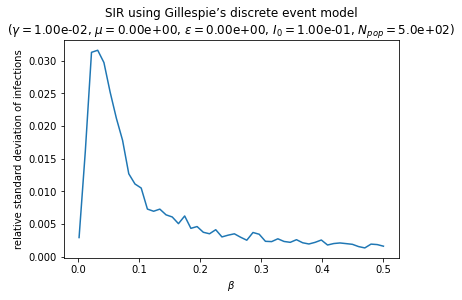

In [28]:
betas = np.linspace(0.001,0.5,50)
per_beta_results = []
for beta in betas:
    config = dict(
        gamma=0.01, mu=0.0, epsilon=0.0, i0=0.1, N_pop=500
    )
    t, results = simulate_sir_demography(
        repetitions=20, beta=beta, **config)
    mean_std = (results[:,:,0] / size).std(axis=0).mean()
    per_beta_results.append(mean_std)
    
per_beta_results = np.array(per_beta_results)
fig, ax = plt.subplots()
ax.plot(betas, per_beta_results)
plt.ylabel("relative standard deviation of infections")
plt.xlabel("$\\beta$")
plt.title((
    "SIR using Gillespie’s discrete event model\n(%s)" % config_str(config)
))
plt.show()

#### Variances and covariance
- Stochastic processes lead to variance in the prevalence of disease.
- Interaction between stochasticity and underlying deterministic nonlinear dynamics leads to negative covariance between number of susceptibles and infectious.
- And because of that, the mean population level $X,Y$ deviate from the deterministic equilibria.


First, we compute the covariance between the number of infected and 
susceptible for network sizes $N_{pop}$ in the range $[40,500]$ to show that indeed, the covariance is negative for all network size, and even higher for small populations.

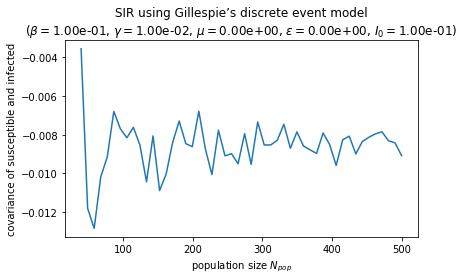

In [29]:
network_sizes = np.linspace(40,500,50)
cov_per_network_size = []
for size in network_sizes:
    config = dict(
        beta=0.1, gamma=0.01, mu=0.0, epsilon=0.0, i0=0.1
    )
    t, results = simulate_sir_demography(repetitions=20, N_pop=size, **config)
    results = np.array(results).mean(axis=0) / size
    cov = np.cov(results[:,0], results[:,1]) # s wrt i
    cov_per_network_size.append(cov)
    
cov_per_network_size = np.array(cov_per_network_size)
fig, ax = plt.subplots()
ax.plot(network_sizes, cov_per_network_size[:,0,1])
plt.ylabel("covariance of susceptible and infected")
plt.xlabel("population size $N_{pop}$")
plt.title((
    "SIR using Gillespie’s discrete event model\n(%s)" % config_str(config)
))
plt.tight_layout()
plt.show()

Now we introduce demography (births and deaths) to the model to show that the mean number of infected individuals deviates from the 
deterministic endemic equilibrium.
Recall that for the deterministic endemic equilibrium, the fraction of infected individuals is given by $I^* = \frac{\mu}{\beta(R_0 - 1.0)}$ with $R_0 = \frac{\beta}{\mu + \gamma}$.

Again, we show this for a small population with $N_{pop} = 100$ and a large population with $N_{pop} = 1000$. We can observe that the deviation from the deterministic equilibrium is again more pronounced for small population sizes.

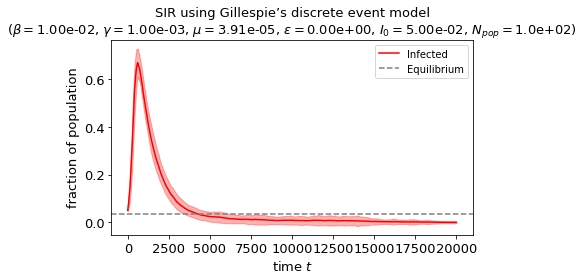

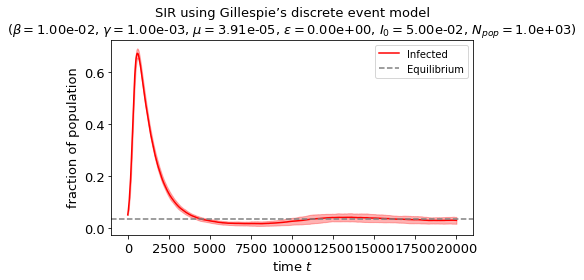

In [30]:
for pop_size in [100, 1000]:
    config = dict(
        beta=0.01, gamma=0.001, mu=1/(70 * 365), epsilon=0.0, i0=0.05,
        N_pop=pop_size
    )
    R_0 = config["beta"] / (config["mu"] + config["gamma"])
    I_equilibrium = config["mu"] / config["beta"] * (R_0 - 1.0)
    t, results = simulate_sir_demography(
        repetitions=100,
        t_end=20_000,
        **config
    )
    fig, ax = plot_sir({
        "Infected": (t.mean(axis=0), results[:,:,1] / pop_size, {})
    }, config=config)
    ax.axhline(y=I_equilibrium, color='gray', label="Equilibrium", linestyle='--')
    plt.ylabel("fraction of population")
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Increased transients
- Stochastic perturbations away from the endemic equilibrium are countered by the restorive forces of the endemic attractor, leading to transient like returns to the endemic equilibrium


Now, we will look closer at the dynamics around the determistic endemic equilibrium.
We can clearly see the sharp transient like behaviour when looking at the time range $[7500, 100_000]$. Note that here, a single repetition was used, to avoid canceling out the transient behaviour.

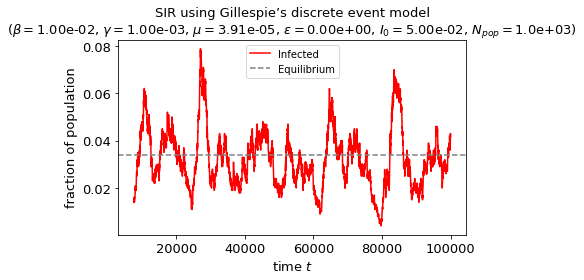

In [31]:
config = dict(
    beta=0.01, gamma=0.001, mu=1/(70 * 365), epsilon=0.0, i0=0.05,
    N_pop=1000
)
R_0 = config["beta"] / (config["mu"] + config["gamma"])
I_equilibrium = config["mu"] / config["beta"] * (R_0 - 1.0)
t, results = simulate_sir_demography(
    repetitions=1, t_end=100_000, **config)
start = 7500
fig, ax = plot_sir({
    "Infected": (
        t.mean(axis=0)[start:],
        results[:,start:,1] / config["N_pop"],
        {},
    )
}, config=config)
ax.axhline(y=I_equilibrium, color='gray', label="Equilibrium", linestyle='--')
plt.ylabel("fraction of population")
plt.legend()
plt.tight_layout()
plt.show()

#### Stochastic Resonance
- Stochastic perturbations can excite oscillations close to the natural frequency of the deterministic SIR dynamics. So, stochasticity can excite epidemic oscillations around the endemic state.


In [32]:
# TODO

#### Extinctions
- For integer-valued stochastic models, stochasticity can lead to extinctions (that is, the number of infectious individuals goes to zero due to fluctuations), even when $R_0 > 1$.
- In closed populations, chance fluctuations will always in the long run lead to extinction of the disease.
- Long term persistence only possible via import of the pathogen
- Similar extinctions may occur during the early stage of invasion.

We again explore the effect of the population size on the probability of extinctions.
We define the mean time of extinction as the mean fraction of the simulation time steps with a number of infected individuals below $1$.
This is due to the integer nature of infections, where in reality, there must be at least one infected individual.

We chose a disease with $R_0 = 10.0$, which clearly shows that due to the fluctuations, extinctions are still possible in stochastic models.
Note that we also introduce imports into the model, with an import rate of $\epsilon = 0.02\sqrt{N_{pop}}$ to make sure the number of infected individuals will eventually grow above the minimum threshold. The population sizes $N_{pop}$ in the range $[10^2,10^5]$ are considered.

n_pop=100 time_extinct=0.49
n_pop=5357 time_extinct=0.22
n_pop=10615 time_extinct=0.18
n_pop=15873 time_extinct=0.16
n_pop=21131 time_extinct=0.15
n_pop=26389 time_extinct=0.14
n_pop=31647 time_extinct=0.13
n_pop=36905 time_extinct=0.13
n_pop=42163 time_extinct=0.13
n_pop=47421 time_extinct=0.13
n_pop=52678 time_extinct=0.13
n_pop=57936 time_extinct=0.13
n_pop=63194 time_extinct=0.13
n_pop=68452 time_extinct=0.12
n_pop=73710 time_extinct=0.12
n_pop=78968 time_extinct=0.12
n_pop=84226 time_extinct=0.11
n_pop=89484 time_extinct=0.12
n_pop=94742 time_extinct=0.12
n_pop=100000 time_extinct=0.12


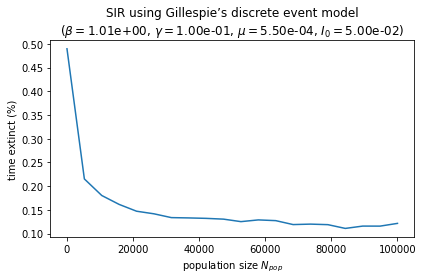

In [33]:
beta = 10 * (5.5*10e-5 + 1/10)
network_sizes = np.linspace(100,100_000,20)
time_extinct_per_population_size = []
config = dict(
    beta=beta, gamma=1/10, mu=5.5*10e-5, i0=0.05,
)
R_0 = config["beta"] / (config["mu"] + config["gamma"])
assert R_0 == 10.0

for N_pop in network_sizes:
    t_end=5 * 365
    t, results = simulate_sir_demography(
        N_pop=size,
        repetitions=50,
        t_end=t_end,
        epsilon=(0.02*np.sqrt(N_pop))/365,
        **config
    )
    extinctions = results[:,:,1] < 1
    mean_extinctions = extinctions.sum(axis=1).mean()
    time_extinct_per_year = (mean_extinctions / (t_end / 365))
    prob_time_extinct_per_year = time_extinct_per_year / 365
    print("n_pop=%d time_extinct=%.2f" % (N_pop, prob_time_extinct_per_year))
    time_extinct_per_population_size.append(prob_time_extinct_per_year)
    
time_extinct_per_population_size = np.array(time_extinct_per_population_size)

fig, ax = plt.subplots()
ax.plot(network_sizes, time_extinct_per_population_size)
plt.ylabel("time extinct (%)")
plt.xlabel("population size $N_{pop}$")
plt.title((
    "SIR using Gillespie’s discrete event model\n(%s)" % config_str(config)
))
plt.tight_layout()
plt.show()

Diseases with a more variable infectious period have greater variability in the number of secondary cases, and therefore a greater risk of extinction when infectious numbers are low. This leads to the critical community size as a persistence measure for the minimum population size $N_c$ required to avoid extinction.

We define $N_c$ as the population size for which the number of extinctions per year is below 2. To show the dependencies of $N_c$ to $R_0$ and $\gamma$, we iteratively find the critical community size $N_c$ for combinations of $R_0$ in the range $[1, 21]$ and $\gamma$ in the range $[50, 550]$.

In [34]:
%%time
R_0s = np.linspace(1, 21, 6)
gammas = np.linspace(50, 550, 6)
result = np.zeros((len(R_0s), len(gammas)))

for (ri, R_0), (gi, gamma) in itertools.product(enumerate(R_0s), enumerate(gammas)):
    # print("searching", R_0, gamma)
    for pop_size in np.linspace(0.5, 7, 10):
        mu = 0.02/365
        t_end=5 * 365
        beta = R_0 * (mu + 1/gamma)
        config = dict(
            beta=beta, gamma=1/gamma, mu=mu, i0=0.05,
            repetitions=2, t_end=t_end
        )
        epsilon=(0.0213*(R_0-1.0)*np.sqrt(N_pop))/365
        t, results = simulate_sir_demography(
            N_pop=10**pop_size, epsilon=epsilon, **config)
        extinctions = results[:,:,1] < 1
        mean_extinctions = extinctions.sum(axis=1).mean()
        time_extinct_per_year = (mean_extinctions / (t_end / 365))
        # print(time_extinct_per_year)
        if time_extinct_per_year < 2:
            result[ri,gi] = pop_size
            print("found", pop_size, "for", R_0, gamma)
            break
print(result)

found 6.277777777777778 for 1.0 50.0
found 3.388888888888889 for 1.0 150.0
found 2.6666666666666665 for 1.0 250.0
found 2.6666666666666665 for 1.0 350.0
found 2.6666666666666665 for 1.0 450.0
found 1.9444444444444444 for 1.0 550.0
found 3.388888888888889 for 5.0 50.0
found 2.6666666666666665 for 5.0 150.0
found 2.6666666666666665 for 5.0 250.0
found 1.9444444444444444 for 5.0 350.0
found 1.9444444444444444 for 5.0 450.0
found 1.9444444444444444 for 5.0 550.0
found 3.388888888888889 for 9.0 50.0
found 3.388888888888889 for 9.0 150.0
found 2.6666666666666665 for 9.0 250.0
found 2.6666666666666665 for 9.0 350.0
found 1.9444444444444444 for 9.0 450.0
found 1.9444444444444444 for 9.0 550.0
found 3.388888888888889 for 13.0 50.0
found 3.388888888888889 for 13.0 150.0
found 2.6666666666666665 for 13.0 250.0
found 2.6666666666666665 for 13.0 350.0
found 1.9444444444444444 for 13.0 450.0
found 1.9444444444444444 for 13.0 550.0
found 3.388888888888889 for 17.0 50.0
found 2.6666666666666665 for 17

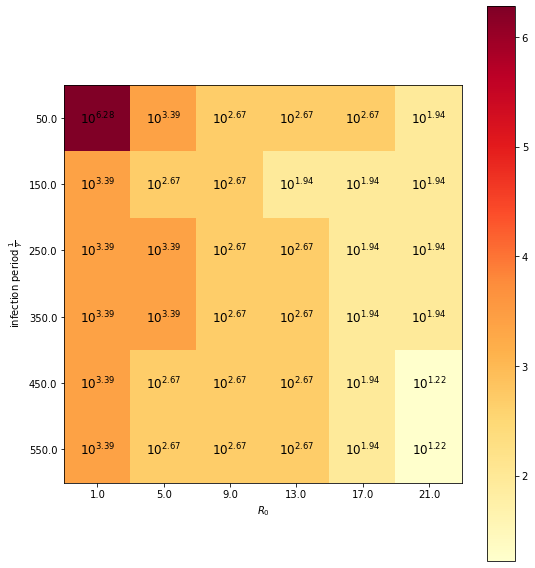

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(result, cmap='YlOrRd')
x, y = np.arange(result.shape[0]), np.arange(result.shape[1])
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xticklabels(R_0s)
ax.set_yticklabels(gammas)
plt.ylabel("infection period $\\frac{1}{\gamma}$")
plt.xlabel("$R_0$")
plt.colorbar(im)
for ix in x:
    for iy in y:
        text = ax.text(iy, ix, "$10^{%.2f}$" % result[ix, iy],
                       ha="center", va="center", color="black", fontsize="large")

plt.tight_layout()
plt.show()

## Problem 2: Metapopulations

Lets start with implementing a simple meta-population
model to study the spatial dynamics of a spreading infection. Start with a stochastic
meta-population model with two sub-populations. Consider two large, fully susceptible populations, with $\rho_{ii} = 1$ and $\rho_{ij} < 1$. Assume the populations are of the same
size, and ignore demography. What is the effect of the coupling between the two
populations, are there any delays?
Now produce a meta-population of your own using more sub populations (Hint: Try
using different strength of interaction between populations), and comment on the
dynamics.

First, we build a variation of the $\verb|SIR_demography|$ discrete event model, which allows keeping track of multiple metapopulations and takes their interactions into account.

In [36]:
class SIR_Metapopulation:
    def __init__(
        self, beta, gamma, p,
        num_metapopulations=2,
        i0s: Union[List[float], float] = 0.05,
        N_pops: Union[List[int], int] = 1000,
    ):
        self.beta = beta
        self.gamma = gamma
        self.p = p
        self.num_metapopulations = num_metapopulations
        self.i0s = (
            [i0s] * self.num_metapopulations
            if not isinstance(i0s, list) else i0s
        )
        self.N_pops = (
            [N_pops] * self.num_metapopulations
            if not isinstance(N_pops, list) else N_pops
        )
        self.N_pop = np.sum(self.N_pops)
        assert len(self.i0s) == self.num_metapopulations
        assert len(self.N_pops) == self.num_metapopulations
    
    def simulate(self, t_end=200):
        t = [0]
        
        I = [[int(i0 * n_pop)] for i0, n_pop in zip(self.i0s, self.N_pops)]
        S = [[n_pop - Ii[0]] for n_pop, Ii in zip(self.N_pops, I)]
        R = [[0] for _ in self.N_pops]
        
        while t[-1] < float(t_end):
            events = dict()
            infected = np.array([
                I[j][-1] for j in range(self.num_metapopulations)
            ])
            for pop in range(self.num_metapopulations):
                transmission = self.beta * S[pop][-1] * np.sum(
                    self.p[pop] * infected
                ) / self.N_pop
                events[(pop, "transmission")] = transmission
                events[(pop, "recovery")] = self.gamma * I[pop][-1]
            
            events = {event: rate for event, rate in events.items() if rate > 0}
            if len(events) < 1:
                break
            
            for pop in range(self.num_metapopulations):
                S[pop].append(S[pop][-1])
                I[pop].append(I[pop][-1])
                R[pop].append(R[pop][-1])
            
            # compute arrival times for each
            event_time = {
                event: -1.0/rate * np.log(np.random.uniform(0, 1))
                for event, rate in events.items()
            }
            
            # choose event that will occur next
            (pop, event), arrival = sorted(event_time.items(), key=lambda x: x[1])[0]
            
            if event == "transmission":
                S[pop][-1] -= 1
                I[pop][-1] += 1
            elif event == "recovery":
                I[pop][-1] -= 1
                R[pop][-1] += 1
            
            t.append(t[-1] + arrival)
        
        t = np.array(t)
        tt = np.linspace(0, t_end, t_end)
        result = []
        for pop in range(self.num_metapopulations):
            Sip = interp1d(t, np.array(S[pop]), fill_value="extrapolate")
            Iip = interp1d(t, np.array(I[pop]), fill_value="extrapolate")
            Rip = interp1d(t, np.array(R[pop]), fill_value="extrapolate")
            pop_result = np.array([Sip(tt), Iip(tt), Rip(tt)]).T
            result.append(pop_result)
        result = np.array(result)
        return t, tt, result
    
def simulate_sir_metapopulations(
    model, t_end=200, repetitions=2,
):
    results, tt = [], None
    for _ in range(repetitions):
        _, tt, result = model.simulate(t_end)
        results.append(result)
    results = np.array(results)
    return tt, results

First of all, we will use 2 metapopulations with a random interaction matrix $p$ and set a fraction $I_0^1 = 0.1$ to be infected in population 1 and $I_0^2 = 0.0$ in population 2. We expect infected individuals from population 1 to slowly infect susceptible individuals in population 2.

[[1.         0.94120716]
 [0.724674   1.        ]]


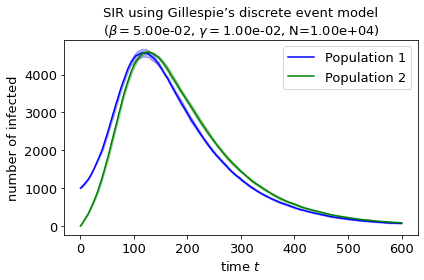

In [37]:
# create random interaction matrix
np.random.seed(42)
p = np.random.uniform(0, 0.99, size=(2,2))
np.fill_diagonal(p, 1)
print(p)

# build metapopulation model
config = dict(
    beta=0.05, gamma=0.01,
)
N = 10_000
num_metapopulations=2
model = SIR_Metapopulation(
    num_metapopulations=num_metapopulations,
    i0s = [0.1, 0.0],
    N_pops = [N, N],
    p = p,
    **config,
)

# run 5 simulations
tt, results = simulate_sir_metapopulations(
    model, t_end=600, repetitions=5,
)
fig, ax = plot_sir({
    "Population 1": (tt, results[:,0,:,1], dict(color="blue")),
    "Population 2": (tt, results[:,1,:,1], dict(color="green")),
}, config={**config, **dict(N=10_000)})
plt.ylabel("number of infected")
plt.tight_layout()
plt.show()

Now we build a meta-population using more sub populations and a different strength of interaction between populations.
As for the interaction matrices, we will try the following:
- unidirectional
- small interaction
- large interaction

In [38]:
n_metapopulations = 10
interaction_mat_size = (n_metapopulations, n_metapopulations)
top_mask = np.zeros(interaction_mat_size, dtype=bool)
for i,j in itertools.product(range(n_metapopulations), range(n_metapopulations)):
    if i<j:
        top_mask[i,j] = True
# print(top_mask)
# print(top_mask.T)

unidirectional1 = np.random.uniform(0.5, 0.5, size=interaction_mat_size)
unidirectional1[top_mask] = 0.0

unidirectional2 = np.random.uniform(0.5, 0.5, size=interaction_mat_size)
unidirectional2[top_mask.T] = 0.0

np.random.seed(42)
ps = [
    (
        "high bidirectional interaction",
        np.random.uniform(0.75, 0.1, size=interaction_mat_size),
    ),
    (
        "medium bidirectional interaction",
        np.random.uniform(0.5, 0.1, size=interaction_mat_size),
    ),
    (
        "low bidirectional interaction",
        np.random.uniform(0.25, 0.1, size=interaction_mat_size),
    ),
    (
        "unidirectional 1", unidirectional1
    ),
    (
        "unidirectional 2", unidirectional2
    ),
]

high bidirectional interaction


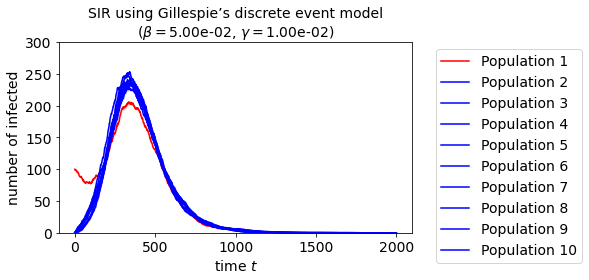

medium bidirectional interaction


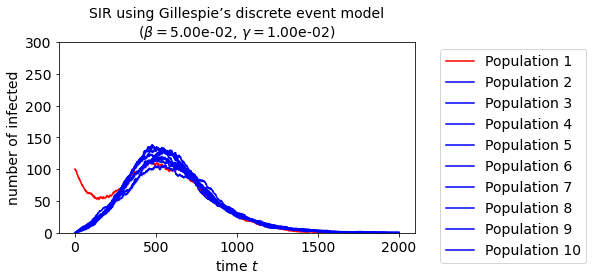

low bidirectional interaction


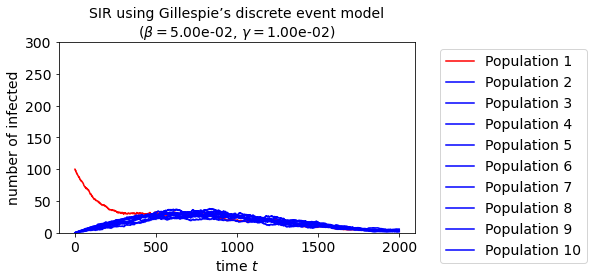

unidirectional 1


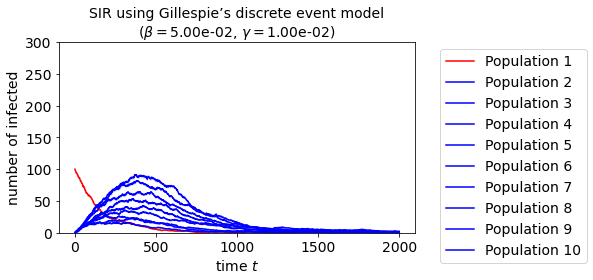

unidirectional 2


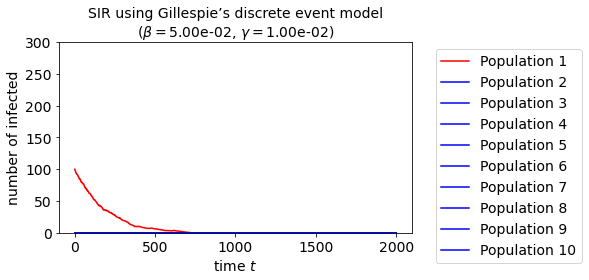

In [39]:
fontsize = 14

for desc, p in ps:
    p = np.clip(p, 0.0, 0.99)
    np.fill_diagonal(p, 1)
    print(desc)
    config = dict(
        beta=0.05, gamma=0.01,
    )
    model = SIR_Metapopulation(
        num_metapopulations=n_metapopulations,
        i0s = [0.1] + ([0.0] * (n_metapopulations - 1)),
        N_pops = [1_000] * n_metapopulations,
        p = p,
        **config,
    )
    results = []
    for _ in range(5):
        _, tt, result = model.simulate(2000)
        results.append(result)
    results = np.array(results)
    
    fig, ax = plot_sir({
            f"Population {pop+1}": (
                tt, results[:,pop,:,1], dict(color="red" if pop == 0 else "blue")
            ) for pop in range(n_metapopulations)
        },
        config=config,
        fontsize=fontsize,
        confidence_scale=0.1,
        confidence_alpha=0.1
    )
    plt.ylim(0, 300)
    plt.legend(loc='upper right', fontsize=fontsize, bbox_to_anchor=(1.5,1))
    plt.ylabel("number of infected", fontsize=fontsize)
    plt.show()

## Network model and Vaccines
In this question you are asked to develop a set
of experiments to design and evaluate vaccination strategies using a network model.
Using the package NDLib1 you should assess the spread of a disease (SIR) across different
types of networks (Barabasi Albert, Watts-Strogatz, Erdos-Reyni).

How to assess the impact/spread of the epidemic (what to measure)

- the best way to stop or slow down an epidemic is **early quarantine** and **early vaccination**
- we therefore focus on measuring the **early behavior** of an epidemic

To get started, we build a SIR network model wrapper using the $\verb|ndlib|$ library.

In [40]:
class SIR_Network:
    def __init__(
        self,
        beta = 0.001,
        gamma = 0.01,
    ):
        self.beta = beta
        self.gamma = gamma
    
    def simulate(
        self,
        graph,
        infected: Union[List[int], float] = 0.05,
        susceptible: Union[List[int], float] = None,
        recovered: Union[List[int], float] = None,
        iterations: int = 200,
        repetitions: int = 1,
        custom=False,
    ):
        config = mc.Configuration()
        config.add_model_parameter('beta', self.beta)
        config.add_model_parameter('gamma', self.gamma)
            
        for comp, param in [
            ("Susceptible", susceptible),
            ("Infected", infected),
            ("Removed", recovered),
        ]:
            if isinstance(param, list):
                config.add_model_initial_configuration(comp, param)
            elif isinstance(param, (float, int)):
                config.add_model_parameter(f"fraction_{comp.lower()}", param)
        
        model = ep.SIRModel(graph)
        if custom:
            model = gc.CompositeModel(graph)

            # Model statuses
            model.add_status("Susceptible")
            model.add_status("Infected")
            model.add_status("Recovered")
            model.add_status("Vaccinated")

            # Compartment definition
            s_to_i = cp.NodeStochastic(self.beta, triggering_status="Infected")
            i_to_r = cp.NodeStochastic(self.gamma)

            # Rule definition
            model.add_rule("Susceptible", "Infected", s_to_i)
            model.add_rule("Infected", "Recovered", i_to_r)

        compartments = list(model.available_statuses.values())
        results = np.zeros((repetitions, iterations, len(compartments)))
        
        for r in range(repetitions):
            # simulate
            model.set_initial_status(config)
            simulations = model.iteration_bunch(iterations)
            
            assert len(simulations) == iterations
            for idx, it in enumerate(simulations):
                for compartment, node_count in it["node_count"].items():
                    results[r, idx, compartment] = node_count
        return results

We will also need utily functions to create different kinds of graphs.

In [41]:
def compute_g_c(R_0, g_k, g_k2):
    return 1.0 - (g_k/(g_k2*R_0))

def get_node_deg_asc(g):
    g_node_degrees = (
        g.degree(g.nodes())
        if not nx.is_directed(g) else g.out_degree(g.nodes())
    )
    g_node_degrees = sorted(list(g_node_degrees), key=lambda x: x[1])
    g_k = np.mean([deg for node, deg in g_node_degrees])
    return g_node_degrees, g_k

def random_graph(R_0, n=500, p=0.01):
    g = nx.erdos_renyi_graph(n=n, p=p)
    g_node_degrees, g_k = get_node_deg_asc(g)
    g_k2 = p*(1 - p)*(n-1) + (p**2)*((n-1)**2)
    return g, g_node_degrees, g_k, g_k2, compute_g_c(R_0, g_k, g_k2)
    
def scale_free_graph(R_0, n=500, m=10):
    g = nx.barabasi_albert_graph(n=n, m=m)
    g_node_degrees, g_k = get_node_deg_asc(g)
    g_k2 = g_k*(1 + g_k)
    return g, g_node_degrees, g_k, g_k2, compute_g_c(R_0, g_k, g_k2)
    
def small_world_graph(R_0, n=500, m=10, p=0.0):
    g = nx.watts_strogatz_graph(n=network_size, k=n_new_edges, p=p)
    g_node_degrees, g_k = get_node_deg_asc(g)
    g_k2 = g_k*(1 + g_k)
    return g, g_node_degrees, g_k, g_k2, compute_g_c(R_0, g_k, g_k2)

##### How to vary disease initalisation - how many and which nodes to start the infection with?

- Ndlib offers a parameter $\verb|frac_infected|$, which is equivalent to randomly initializing nodes to be infected. For the following experiments, we will fix $I_0 = 0.1 * N_{pop}$ initial infected nodes and use the following strategies to choose the $I_0$ nodes:
1. Choose the $I_0$ nodes with the highest degree, we expect the disease to spread faster due to the high number of neighbors
2. Choose the $I_0$ nodes with the smallest degree, we expect the disease to spread slower or go extinct due to the low number of neighbors
3. Choose $I_0$ nodes randomly, which will be a compromise between 1 and 2 as for large sample sizes the expectation will approximate the mean node degree in the graph. For smaller samples, there can be significant variation.

R_0=1.00
random (Erdos-Renyi)  <k>=4.81  <k2>=29.84  g_c=0.84


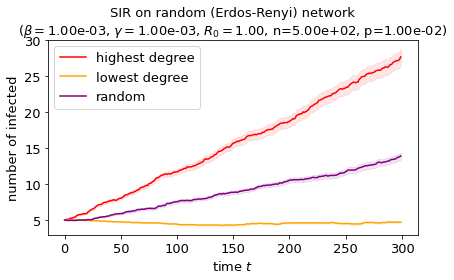

scale-free (Barabási-Albert)  <k>=19.60  <k2>=403.76  g_c=0.95


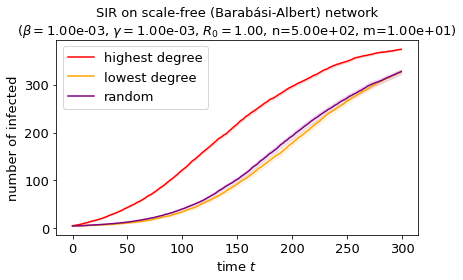

small-world (Watts-Strogatz)  <k>=10.00  <k2>=110.00  g_c=0.91


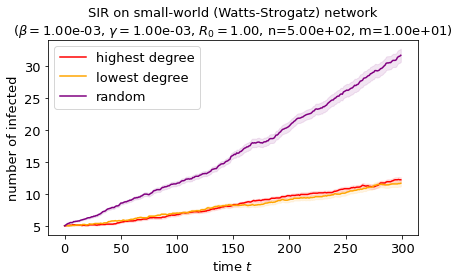

In [42]:
edge_prob = 0.01
network_size = 5_00
n_new_edges = 10
small_world_n_new_edges = 10

I_0_frac = 0.01
I_0 = int(I_0_frac * network_size)

beta = 0.001
gamma = 0.001
R_0 = beta/gamma
print("R_0=%0.2f" % R_0)

config = dict(
    beta = beta, gamma = gamma
)
model = SIR_Network(**config)

iterations=3_00
repetitions=20
fontsize = 13

for graph_type, builder, graph_params in [
    ("random (Erdos-Renyi)", random_graph, dict(R_0=R_0, n=network_size, p=edge_prob)),
    ("scale-free (Barabási-Albert)", scale_free_graph, dict(R_0=R_0, n=network_size, m=n_new_edges)),
    ("small-world (Watts-Strogatz)", small_world_graph, dict(R_0=R_0, n=network_size, m=small_world_n_new_edges)),
]:
    graph, node_degrees_asc, k, k2, g_c = builder(**graph_params)
    print("%s  <k>=%.2f  <k2>=%.2f  g_c=%.2f" % (graph_type, k, k2, g_c))
    model.beta = beta
    model.gamma = gamma
    
    np.random.seed(42)
    strategies = [
        ("highest degree", [n for n, deg in node_degrees_asc[-I_0:]]),
        ("lowest degree", [n for n, deg in node_degrees_asc[:I_0]]),
        ("random", np.random.choice(graph.nodes(), size=I_0, replace=False).tolist()),
    ]
    assert all([len(nodes) == I_0 for _, nodes in strategies])
    
    per_strategy_results = []
    for strategy, infected in strategies:
        nodes = set(graph.nodes())
        susceptible = nodes - set(infected)
        
        results = model.simulate(
            graph,
            infected=infected,
            susceptible=list(susceptible),
            recovered=[],
            iterations=iterations,
            repetitions=repetitions
        )
        per_strategy_results.append(results)
    per_strategy_results = np.array(per_strategy_results)
    
    colors = ["red", "orange", "purple"]
    fig, ax = plot_sir({
            f"{strategy}": (
                np.arange(iterations),
                per_strategy_results[idx,:,:,1],
                dict(color=colors[idx]),
            ) for idx, (strategy, _) in enumerate(strategies)
        },
        fontsize=fontsize,
        config=dict(),
        confidence_scale=0.1,
        confidence_alpha=0.1
    )
    plt.title("SIR on %s network\n(%s)" % (
        graph_type, config_str({**config, **graph_params})
    ), fontsize=fontsize)
    plt.ylabel("number of infected", fontsize=fontsize)
    plt.tight_layout()
    plt.show()

##### Vaccine strategy

Design and evaluate a vaccine strategy and test its effectiveness on the different
networks. This vaccine strategy should decide which nodes to vaccinate - you
might consider strategies where you know the network structure OR strategies
where you don’t have global network information (i.e., deliver at random).

R_0=3.00
random (Erdos-Renyi)  <k>=5.00  <k2>=29.84  g_c=0.94
$\beta=$3.00e-03, $\gamma=$1.00e-03, $R_0=$3.00, n=5.00e+02, p=1.00e-02


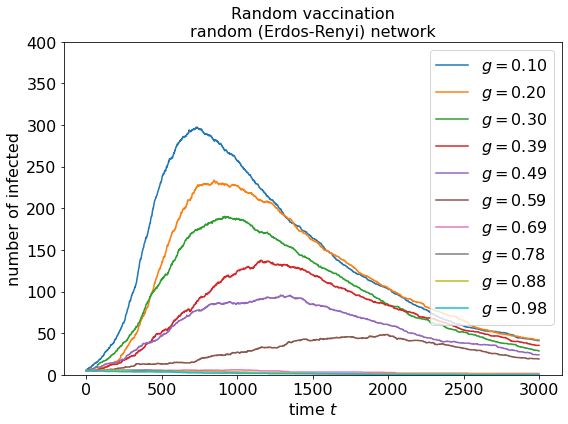

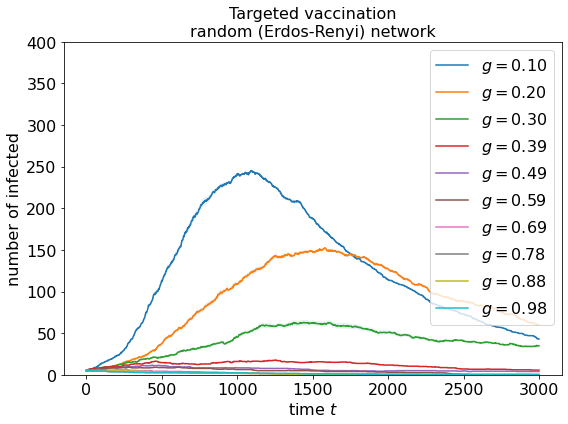

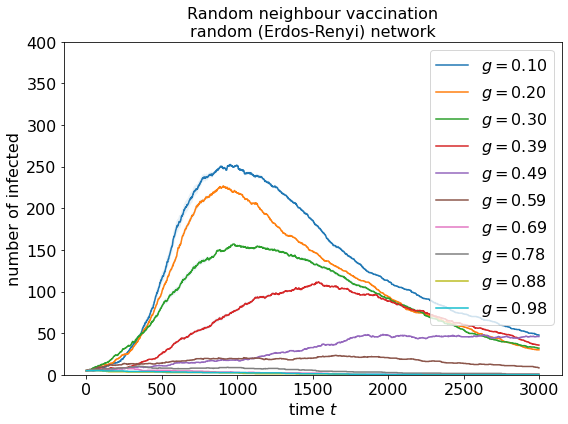

scale-free (Barabási-Albert)  <k>=19.60  <k2>=403.76  g_c=0.98
$\beta=$3.00e-03, $\gamma=$1.00e-03, $R_0=$3.00, n=5.00e+02, m=1.00e+01


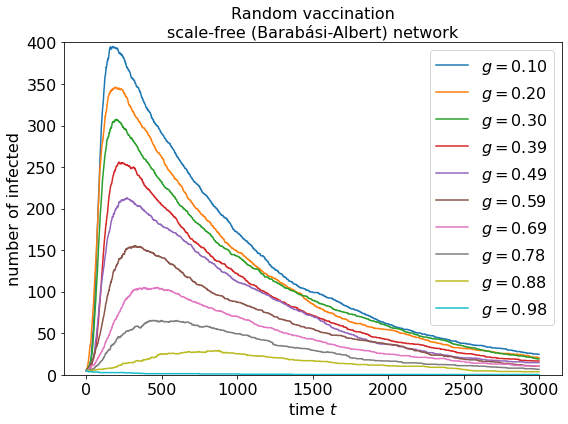

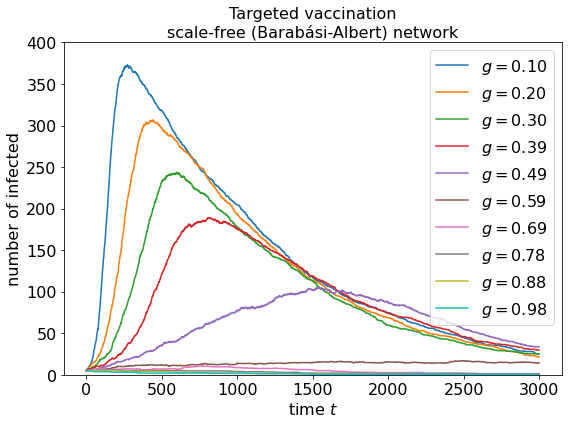

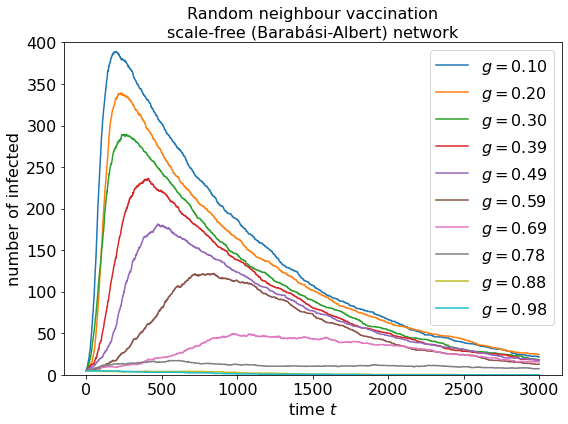

small-world (Watts-Strogatz)  <k>=10.00  <k2>=110.00  g_c=0.97
$\beta=$3.00e-03, $\gamma=$1.00e-03, $R_0=$3.00, n=5.00e+02, m=1.00e+01


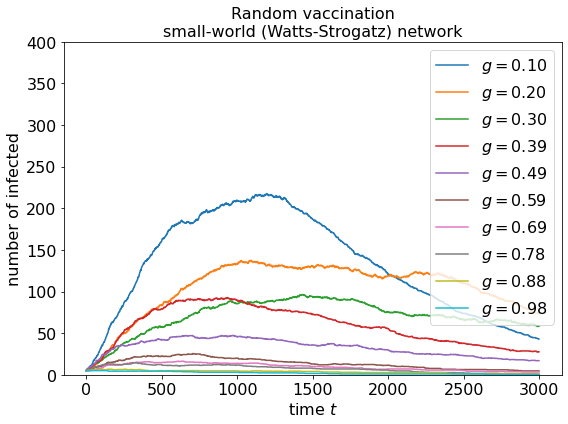

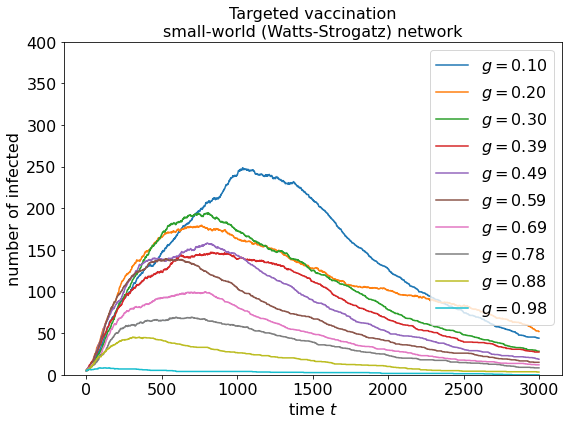

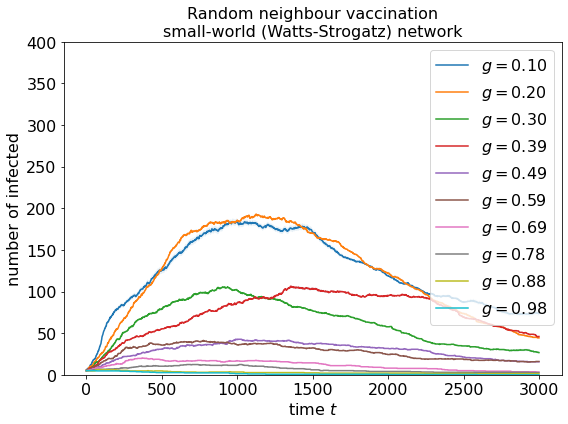

CPU times: user 6min 49s, sys: 1.92 s, total: 6min 51s
Wall time: 6min 49s


In [43]:
%%time
edge_prob = 0.01
network_size = 500
n_new_edges = 10
small_world_n_new_edges = 10

I_0_frac = 0.01
I_0 = int(I_0_frac * network_size)

beta = 0.003
gamma = 0.001
R_0 = beta/gamma
print("R_0=%0.2f" % R_0)

config = dict(
    beta = beta, gamma = gamma
)
model = SIR_Network(**config)

iterations=3_000
repetitions=3
fontsize = 16
figsize = (8,6)

for graph_type, builder, graph_params in [
    ("random (Erdos-Renyi)", random_graph, dict(R_0=R_0, n=network_size, p=edge_prob)),
    ("scale-free (Barabási-Albert)", scale_free_graph, dict(R_0=R_0, n=network_size, m=n_new_edges)),
    ("small-world (Watts-Strogatz)", small_world_graph, dict(R_0=R_0, n=network_size, m=small_world_n_new_edges)),
]:
    graph, node_degrees_asc, k, k2, g_c = builder(**graph_params)
    print("%s  <k>=%.2f  <k2>=%.2f  g_c=%.2f" % (graph_type, k, k2, g_c))
    print(config_str({**config, **graph_params}))
    model.beta = beta
    model.gamma = gamma
    
    # random vaccination
    per_g_results = []
    gs = np.linspace(0.1, 1.0-2*I_0_frac, 10)
    for g in gs:
        nodes = set(graph.nodes())
        infected = set(np.random.choice(list(nodes), size=I_0, replace=False))
        susceptible = nodes - infected
        recovered = set(np.random.choice(
            list(susceptible), size=int(g * network_size), replace=False))
        susceptible = susceptible - recovered
        assert len(susceptible.union(infected).union(recovered)) == len(nodes)

        results = model.simulate(
            graph,
            susceptible=list(susceptible),
            infected=list(infected),
            recovered=list(recovered),
            iterations=iterations,
            repetitions=repetitions
        )
        per_g_results.append(results)
    
    per_g_results = np.array(per_g_results)
    fig, ax = plot_sir({
            "$g=%.2f$" % g: (
                np.arange(iterations),
                per_g_results[idx,:,:,1],
                dict(),
            ) for idx, g in enumerate(gs)
        },
        title="Random vaccination\n%s network" % (
            graph_type
        ),
        figsize=figsize,
        fontsize=fontsize,
        config=dict(),
        confidence_scale=0.1,
        confidence_alpha=0.1
    )
    plt.ylabel("number of infected", fontsize=fontsize)
    plt.legend(loc='upper right', fontsize=fontsize)
    plt.ylim(0, 400)
    plt.tight_layout()
    plt.show()
    
    # targeted vaccination
    per_g_results = []
    gs = np.linspace(0.1, 1.0-2*I_0_frac, 10)
    for g in gs:
        nodes = set(graph.nodes())
        
        recovered = set([n for n, deg in node_degrees_asc[-int(g * network_size):]])
        susceptible = nodes - recovered
        infected = set(np.random.choice(list(susceptible), size=I_0, replace=False))
        susceptible = susceptible - infected
        assert len(susceptible.union(infected).union(recovered)) == len(nodes)

        results = model.simulate(
            graph,
            susceptible=list(susceptible),
            infected=list(infected),
            recovered=list(recovered),
            iterations=iterations,
            repetitions=repetitions
        )
        per_g_results.append(results)
        
    per_g_results = np.array(per_g_results)
    fig, ax = plot_sir({
            "$g=%.2f$" % g: (
                np.arange(iterations),
                per_g_results[idx,:,:,1],
                dict(),
            ) for idx, g in enumerate(gs)
        },
        title="Targeted vaccination\n%s network" % (
            graph_type
        ),
        figsize=figsize,
        fontsize=fontsize,
        config=dict(),
        confidence_scale=0.1,
        confidence_alpha=0.1
    )
    plt.ylabel("number of infected", fontsize=fontsize)
    plt.legend(loc='upper right', fontsize=fontsize)
    plt.ylim(0, 400)
    plt.tight_layout()
    plt.show()
    
    # random neighbour vaccination
    per_g_results = []
    gs = np.linspace(0.1, 1.0-2*I_0_frac, 10)
    for g in gs:
        nodes = set(graph.nodes())
        
        # Select a random individual, then immunize one of its RANDOMLY CHOSEN FRIENDs.
        # If you follow an edge, you are likely to meet high-degree nodes!
        nodes_with_neighbours = [
            n for n, deg in node_degrees_asc if deg > 0
        ]
        assert len(nodes_with_neighbours) > int(g * network_size)
        
        recovered = set()
        while len(recovered) < int(g * network_size):
            # choose random neigbour node
            node = np.random.choice(nodes_with_neighbours, size=1)[0]
            neighbour = np.random.choice(list(graph.neighbors(node)), size=1)[0]
            recovered.add(neighbour) # no duplicates
            
        assert len(recovered) == int(g * network_size)
        susceptible = nodes - recovered
        infected = set(np.random.choice(list(susceptible), size=I_0, replace=False))
        susceptible = susceptible - infected
        assert len(susceptible.union(infected).union(recovered)) == len(nodes)

        results = model.simulate(
            graph,
            susceptible=list(susceptible),
            infected=list(infected),
            recovered=list(recovered),
            iterations=iterations,
            repetitions=repetitions
        )
        per_g_results.append(results)
        
    per_g_results = np.array(per_g_results)
    fig, ax = plot_sir({
            "$g=%.2f$" % g: (
                np.arange(iterations),
                per_g_results[idx,:,:,1],
                dict(),
            ) for idx, g in enumerate(gs)
        },
        title="Random neighbour vaccination\n%s network" % (
            graph_type
        ),
        figsize=figsize,
        fontsize=fontsize,
        config=dict(),
        confidence_scale=0.1,
        confidence_alpha=0.1
    ) 
    plt.ylabel("number of infected", fontsize=fontsize)
    plt.legend(loc='upper right', fontsize=fontsize)
    plt.ylim(0, 400)
    plt.tight_layout()
    plt.show()